# **Customer Segmentation**

# **Milestone 2**

**Note:** This is in continuation to the data preprocessing we did in Milestone 1. Results might differ if you have followed different steps in data preprocessing. 

## Preparing Data for Segmentation

### Dropping columns that we will not use for segmentation

The decision about which variables to use for clustering is a critically important decision that will have a big impact on the clustering solution. So we need to think carefully about the variables we will choose for clustering. Clearly, this is a step where a lot of contextual knowledge, creativity, and experimentation/iterations are needed.

Moreover, we often use only a few of the data attributes for segmentation (the segmentation attributes) and use some of the remaining ones (the profiling attributes) only to profile the clusters. For example, in market research and market segmentation, we can use behavioral data for segmentation (to segment the customers based on their behavior like amount spent, units bought, etc.), and then use both demographic as well as behavioral data for profiling the segments found.

Here, we will use the behavioral attributes for segmentation and drop the demographic attributes like Income, Age, and Family_Size. In addition to this, we need to drop some other columns which are mentioned below.

* `Dt_Customer`: We have created the `Engaged_in_days` variable using the Dt_Customer variable. Hence, we can drop this variable as it will not help with segmentation.
* `Complain`: About 95% of the customers didn't complain and have the same value for this column. This variable will not have a major impact on segmentation. Hence, we can drop this variable. 
* `day`:  We have created the `Engaged_in_days` variable using the 'day' variable. Hence, we can drop this variable as it will not help with segmentation.
* `Status`: This column was created just to get the `Family_Size` variable that contains the information about the Status. Hence, we can drop this variable.
* We also need to drop categorical variables like `Education` and `Marital_Status`, `Kids`, `Kidhome`, and `Teenhome` as distance-based algorithms cannot use the default distance like Euclidean to find the distance between categorical and numerical variables.
* We can also drop categorical variables like `AcceptedCmp1`, `AcceptedCmp2`, `AcceptedCmp3`, `AcceptedCmp4`, `AcceptedCmp5`, and `Response` for which we have create the variable `TotalAcceptedCmp` which is the aggregate of all these variables.

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# To compute distances
from scipy.spatial.distance import cdist

# To perform K-means clustering and compute Silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# To visualize the elbow curve and Silhouette scores
from yellowbrick.cluster import SilhouetteVisualizer

# Importing PCA
from sklearn.decomposition import PCA

# To encode the variable
from sklearn.preprocessing import LabelEncoder

# Importing TSNE
from sklearn.manifold import TSNE

# To perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# To compute distances
from scipy.spatial.distance import pdist

# To import K-Medoids
from sklearn_extra.cluster import KMedoids

# To import DBSCAN 
from sklearn.cluster import DBSCAN

# To import Gaussian Mixture
from sklearn.mixture import GaussianMixture

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# loading the dataset
data = pd.read_csv("marketing_campaign_milestone2.csv")

In [2]:
# Dropping all the irrelevant columns and storing in data_model
data_model = data.drop(
    columns=[
        "Year_Birth",
        "Dt_Customer",
        "day",
        "Complain",
        "Response",
        "AcceptedCmp1",
        "AcceptedCmp2",
        "AcceptedCmp3",
        "AcceptedCmp4",
        "AcceptedCmp5",
        "Marital_Status",
        "Status",
        "Kids",
        'Education',
        'Kidhome',
        'Teenhome', 'Income','Age', 'Family_Size'
    ],
    axis=1,
)

In [3]:
# Check the shape of new data 
data_model.shape

(2227, 17)

In [4]:
# Check first five rows of new data
data_model.head()

,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Expenses,NumTotalPurchases,Engaged_in_days,TotalAcceptedCmp,AmountPerPurchase
0,58,635,88,546,172,88,88,3,8,10,4,7,1617,25,997,1,64.680000
1,38,11,1,6,2,1,6,2,1,1,2,5,27,6,151,0,4.500000
2,26,426,49,127,111,21,42,1,8,2,10,4,776,21,498,0,36.952381
3,26,11,4,20,10,3,5,2,2,0,4,6,53,8,91,0,6.625000
4,94,173,43,118,46,27,15,5,5,3,6,5,422,19,347,0,22.210526


**Let's plot the correlation plot after we've removed the irrelevant variables.**

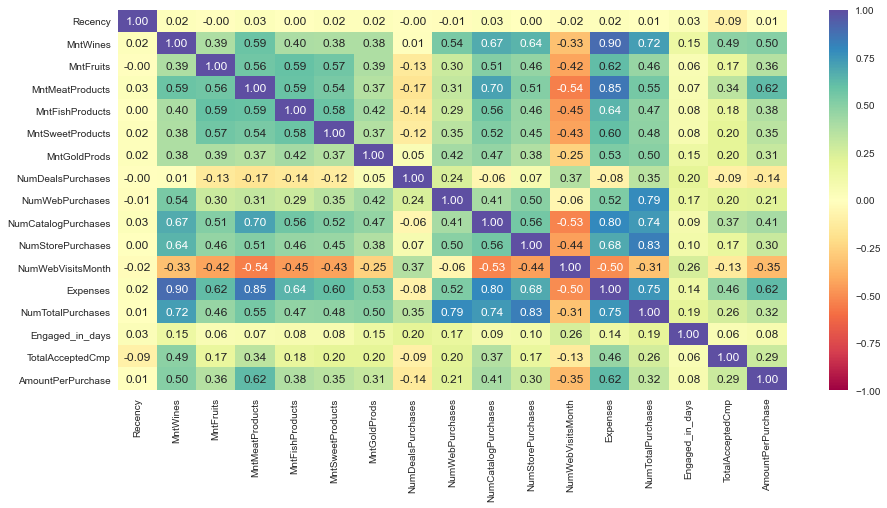

In [5]:
# Plot the correlation plot for new data
plt.figure(figsize=(15, 7))                                                        # Setting the plot size
sns.heatmap(data_model.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")  # Plotting the correlation plot
plt.show()

**Observations and Insights:**

- There is a strong positive correlation between expenses and amount spent on wine and meat products in the past 2 years.  This may suggest that these are more expensive products that greatly contributes to a customer's overall expenses.
- There is also a strong positive correlation between amount spent on wine products in the past 2 years and amount spent on meat products in the past 2 years, number of purchases made through the company's website, number of purchases made using a catalog, number of purchases made directly in stores, number of total purchases from each channel, total campaigns accepted, and amount spent per purchase.
- Number of visits to the company's website in the last month has a moderately strong negative correlation to amount spent on wine, fruits, meat, fish, sweet, and gold products in the past 2 years.
- There is a strong positive correlation between number of total purchases and number of purchases made through the company's website or directly in stores.
- There is also a strong positive correlation between number of purchases made using a catalog and expenses.
- The negative correlation between number of visits to the company's website in the last month and number of purchases made using a catalog or directly in stores makes sense because if customers are using these channels to make purchases, they probably don't have to visit the company's website.
- The moderately strong positive correlation between expenses and number of total purchases and amount per purchase makes sense because if a customer spends more, they probably made more purchases and spent more for each purchase.
- There is a negative correlation between expenses and number of visits to the company's website in the last month.

### Scaling the Data

**What is feature scaling?**

Feature scaling is a class of statistical techniques that, as the name implies, scales the features of our data so that they all have a similar range. You'll understand better if we look at an example:

If you have multiple independent variables like Age, Income, and Amount related variables, with their range as (18–100 Years), (25K–75K), and (100–200), respectively, feature scaling would help them all to be in the same range.

**Why feature scaling is important in Unsupervised Learning?**

Feature scaling is especially relevant in machine learning models that compute some sort of distance metric as we do in most clustering algorithms, for example, K-Means. 

So, scaling should be done to avoid the problem of one feature dominating over others because the unsupervised learning algorithm uses distance to find the similarity between data points.

**Let's scale the data**

**Standard Scaler**: StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation.

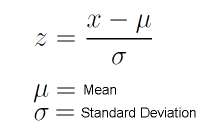

1. Data standardization is the process of rescaling the attributes so that they have a mean of 0 and a variance of 1.
2. The ultimate goal to perform standardization is to bring down all the features to a common scale without distorting the differences in the range of the values.
3. In sklearn.preprocessing.StandardScaler(), centering and scaling happen independently on each feature.

In [6]:
# Applying standard scaler on new data
scaler = StandardScaler()                                                   # Initialize the Standard Scaler

df_scaled = scaler.fit_transform(data_model)                                        # fit_transform the scaler function on new data

df_scaled = pd.DataFrame(df_scaled, columns=data_model.columns)      # Converting the embeddings to a dataframe

df_scaled.head()

,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Expenses,NumTotalPurchases,Engaged_in_days,TotalAcceptedCmp,AmountPerPurchase
0,0.306906,0.979274,1.549793,1.735137,2.455586,1.471064,0.841828,0.357919,1.404892,2.633008,-0.561330,0.696875,1.682349,1.329371,1.975678,0.619416,0.697428
1,-0.384035,-0.873925,-0.638021,-0.726901,-0.652191,-0.633425,-0.732464,-0.169952,-1.119121,-0.586255,-1.178960,-0.135935,-0.963691,-1.167064,-1.667464,-0.503906,-0.638991
2,-0.798600,0.358572,0.569049,-0.175222,1.340442,-0.149634,-0.041311,-0.697824,1.404892,-0.228559,1.291559,-0.552339,0.282777,0.803806,-0.173173,-0.503906,0.081680
3,-0.798600,-0.873925,-0.562579,-0.663070,-0.505942,-0.585045,-0.751662,-0.169952,-0.758548,-0.943951,-0.561330,0.280470,-0.920422,-0.904281,-1.925843,-0.503906,-0.591801
4,1.550599,-0.392806,0.418165,-0.216256,0.152175,-0.004497,-0.559676,1.413662,0.323172,0.129137,0.056299,-0.135935,-0.306341,0.541023,-0.823427,-0.503906,-0.245693


## **Applying T-SNE and PCA to the data to visualize the data distributed in 2 dimensions**

### **Applying T-SNE**

<AxesSubplot:xlabel='0', ylabel='1'>

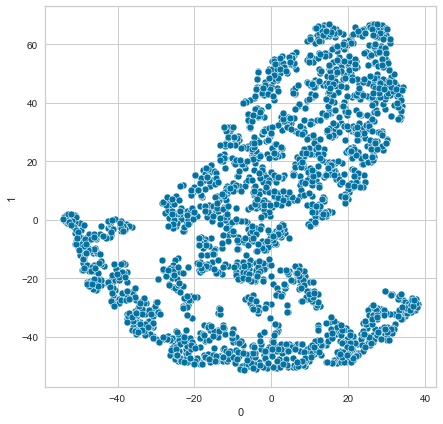

In [7]:
# Fitting T-SNE with number of components equal to 2 to visualize how data is distributed

tsne = TSNE(n_components=2, random_state=1, perplexity=35)        # Initializing T-SNE with number of component equal to 2, random_state=1, and perplexity=35

data_air_pol_tsne = tsne.fit_transform(data_model)                            # fit_transform T-SNE on new data

data_air_pol_tsne = pd.DataFrame(data_air_pol_tsne, columns=[0, 1])           # Converting the embeddings to a dataframe

plt.figure(figsize=(7, 7))                                                    # Scatter plot for two components

sns.scatterplot(x=data_air_pol_tsne.iloc[:,0], y=data_air_pol_tsne.iloc[:,1], data=data_air_pol_tsne)                             # Plotting T-SNE

### **Applying PCA**

**Think about it:**
- Should we apply clustering algorithms on the current data or should we apply PCA on the data before applying clustering algorithms? How would this help?

When the variables used in clustering are highly correlated, it causes multicollinearity, which affects the clustering method and results in poor cluster profiling (or biased toward a few variables). PCA can be used to reduce the multicollinearity between the variables. 

In [8]:
# Defining the number of principal components to generate
n = data_model.shape[1]                                        # Storing the number of variables in the data

pca = PCA(n_components=n, random_state = 1)                                        # Initialize PCA with n_components = n and random_state=1

data_pca = pd.DataFrame(pca.fit_transform(df_scaled))                      # fit_transform PCA on the scaled data

# The percentage of variance explained by each principal component is stored
exp_var = pca.explained_variance_ratio_                     

**Let's plot the first two components and see how the data points are distributed.**

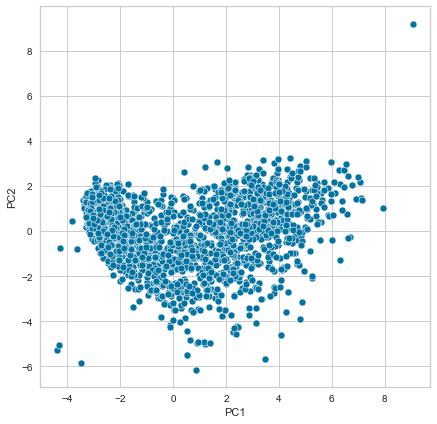

In [9]:
# Scatter plot for two components using the dataframe data_pca
plt.figure(figsize = (7, 7))

sns.scatterplot(x = data_pca[0], y = data_pca[1])

plt.xlabel("PC1")

plt.ylabel("PC2")

plt.show()

**Let's apply clustering algorithms on the data generated after applying PCA**

## **K-Means** 

In [10]:
distortions = []                                                  # Create an empty list

K = range(2, 10)                                                  # Setting the K range from 2 to 10

for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=4)              # Initialize K-Means
    kmeanModel.fit(data_pca)                                      # Fit K-Means on the data
    distortions.append(kmeanModel.inertia_)                       # Append distortion values to the empty list created above

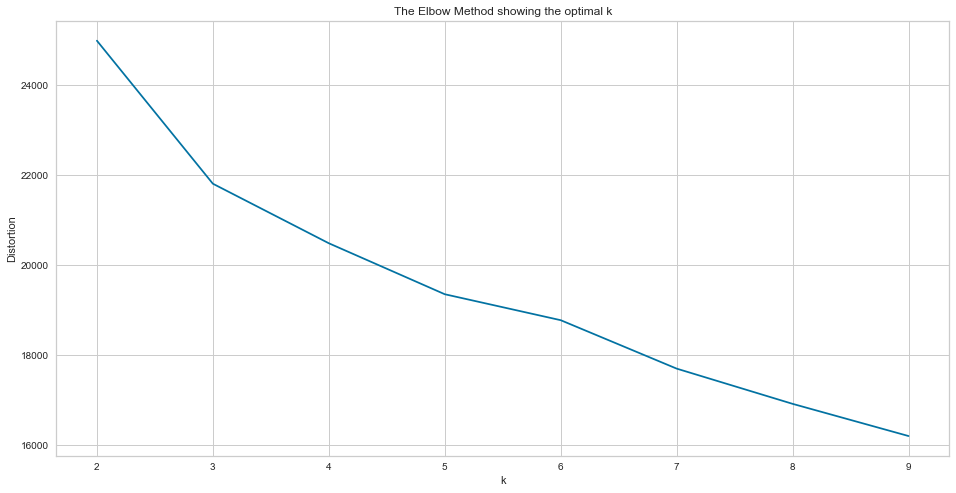

In [11]:
# Plotting the elbow plot
plt.figure(figsize=(16, 8))                                            # Setting the plot size

plt.plot(K, distortions, "bx-")                                        # Plotting the K on X-axis and distortions on y-axis

plt.xlabel("k")                                                        # Title of x-axis

plt.ylabel("Distortion")                                               # Title of y-axis

plt.title("The Elbow Method showing the optimal k")                    # Title of the plot
plt.show()

**In the above plot, the elbow is seen for K=3 and K=5 as there is some drop in distortion at K=3 and K=5.**

**Think About It:**

- How do we determine the optimal K value when the elbows are observed at 2 or more K values from the elbow curve?
- Which metric can be used to determine the final K value?

**We can use the silhouette score as a metric for different K values to make a better decision about picking the number of clusters(K).**

### **What is the silhouette score?**

Silhouette score is one of the methods for evaluating the quality of clusters created using clustering algorithms such as K-Means. The silhouette score is a measure of how similar an object is to its cluster (cohesion) compared to other clusters (separation). Silhouette score has a range of [-1, 1].

* Silhouette coefficients near +1 indicate that the clusters are dense and well separated, which is good.
* Silhouette score near -1 indicates that those samples might have been assigned to the wrong cluster.

**Finding silhouette score for each value of K**

In [12]:
sil_score = []                                                             # Creating empty list
cluster_list = range(3, 7)                                                 # Creating a range from 3 to 7
for n_clusters in cluster_list:
    
    # Initialize K-Means with number of clusters equal to n_clusters and random_state=1
    clusterer = KMeans(n_clusters = k, random_state = 1).fit(data_pca)
    
    # Fit and predict on the pca data
    preds = clusterer.fit_predict(data_pca) 
    
    # Calculate silhouette score - Hint: Use silhouette_score() function
    score = silhouette_score(data_pca, preds)  
    
    # Append silhouette score to empty list created above
    sil_score.append(score)   
    
    # Print the silhouette score
    print( "For n_clusters = {}, the silhouette score is {}".format(n_clusters, score))  

For n_clusters = 3, the silhouette score is 0.13021374284739756
For n_clusters = 4, the silhouette score is 0.13021374284739756
For n_clusters = 5, the silhouette score is 0.13021374284739756
For n_clusters = 6, the silhouette score is 0.13021374284739756


**From the above silhouette scores, 3 appears to be a good value of K. So, let's build K-Means using K=3.**

### **Applying K-Means on data_pca**

In [13]:
kmeans = KMeans(n_clusters = 3, random_state = 1)                                # Initialize the K-Means algorithm with 3 clusters and random_state=1

kmeans.fit(data_pca)                                     # Fitting on the data_pca

KMeans(n_clusters=3, random_state=1)

In [14]:
data_pca["K_means_segments_3"] = kmeans.labels_                    # Adding K-Means cluster labels to the data_pca data

data["K_means_segments_3"] = kmeans.labels_                        # Adding K-Means cluster labels to the whole data

data_model["K_means_segments_3"] = kmeans.labels_                  # Adding K-Means cluster labels to data_model

In [15]:
# Let's check the distribution
data_model["K_means_segments_3"].value_counts()

1    1058
0     607
2     562
Name: K_means_segments_3, dtype: int64

**Let's visualize the clusters using PCA**

In [16]:
# Function to visualize PCA data with clusters formed
def PCA_PLOT(X, Y, PCA, cluster):
    sns.scatterplot(x=X, y=Y, data=PCA, hue=cluster)

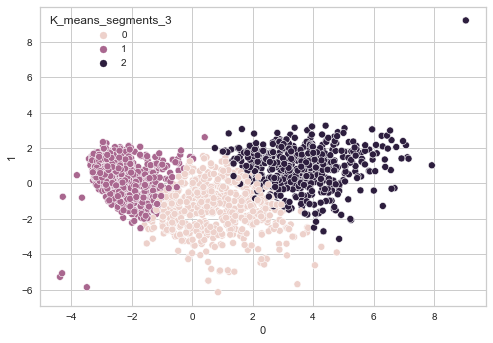

In [17]:
PCA_PLOT(data_pca[0], data_pca[1], data_pca, "K_means_segments_3")

### **Cluster Profiling**

In [18]:
# Taking the cluster-wise mean of all the variables. Hint: First groupby 'data' by 'K_means_segments_3' and then find mean
cluster_profile_KMeans_3 = data.groupby('K_means_segments_3').mean()

In [19]:
# Highlighting the maximum average value among all the clusters for each of the variables
cluster_profile_KMeans_3.style.highlight_max(color="lightgreen", axis=0)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Kids,Status,Family_Size,Expenses,NumTotalPurchases,Engaged_in_days,TotalAcceptedCmp,AmountPerPurchase
K_means_segments_3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1965.925865,57680.085667,0.281713,0.843493,47.673806,454.586491,23.186161,138.413509,30.570016,24.663921,62.253707,3.782537,6.492586,3.107084,7.883031,5.752883,0.070840,0.125206,0.023064,0.036244,0.014827,0.008237,0.133443,50.074135,1.125206,1.657331,2.782537,733.673806,21.265239,593.739703,0.403624,34.359878
1,1970.975425,35331.837429,0.755198,0.475425,49.260870,45.191871,5.068998,23.705104,7.374291,5.169187,15.291115,2.026465,2.142722,0.572779,3.294896,6.376181,0.068053,0.015123,0.000000,0.000945,0.001890,0.010397,0.084121,45.024575,1.230624,1.652174,2.882798,101.800567,8.036862,500.201323,0.170132,11.321001
2,1968.160142,75902.170819,0.035587,0.206406,50.402135,633.585409,69.914591,461.421708,102.395018,71.357651,78.932384,1.300712,5.215302,6.023132,8.336299,2.889680,0.085409,0.133452,0.263345,0.215302,0.032028,0.007117,0.291815,47.839858,0.241993,1.617438,1.859431,1417.606762,20.875445,549.802491,1.021352,73.430131


**Observations and Insights:**

- Cluster 2 is the smallest cluster (562 customers) and it consists of customers with the highest income.  These customers seem to spend the most on products and don't really use deals when purchasing items.
- Cluster 1 has the youngest cluster of customers and the customers in this cluster have the lowest income on average as well.  These customers seem to spend less on products.  This is also the largest cluster with 1058 customers.
- Cluster 0 includes middle-income customers who don't spend a ton on products but also not a very small amount like Cluser 1.  These customers also had the most purchases using deals.

**Let us create a boxplot for each of the variables**

In [20]:
# Columns to use in boxplot
col_for_box = ['Income','Kidhome','Teenhome','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Complain','Age','Family_Size','Expenses','NumTotalPurchases','Engaged_in_days','TotalAcceptedCmp','AmountPerPurchase']

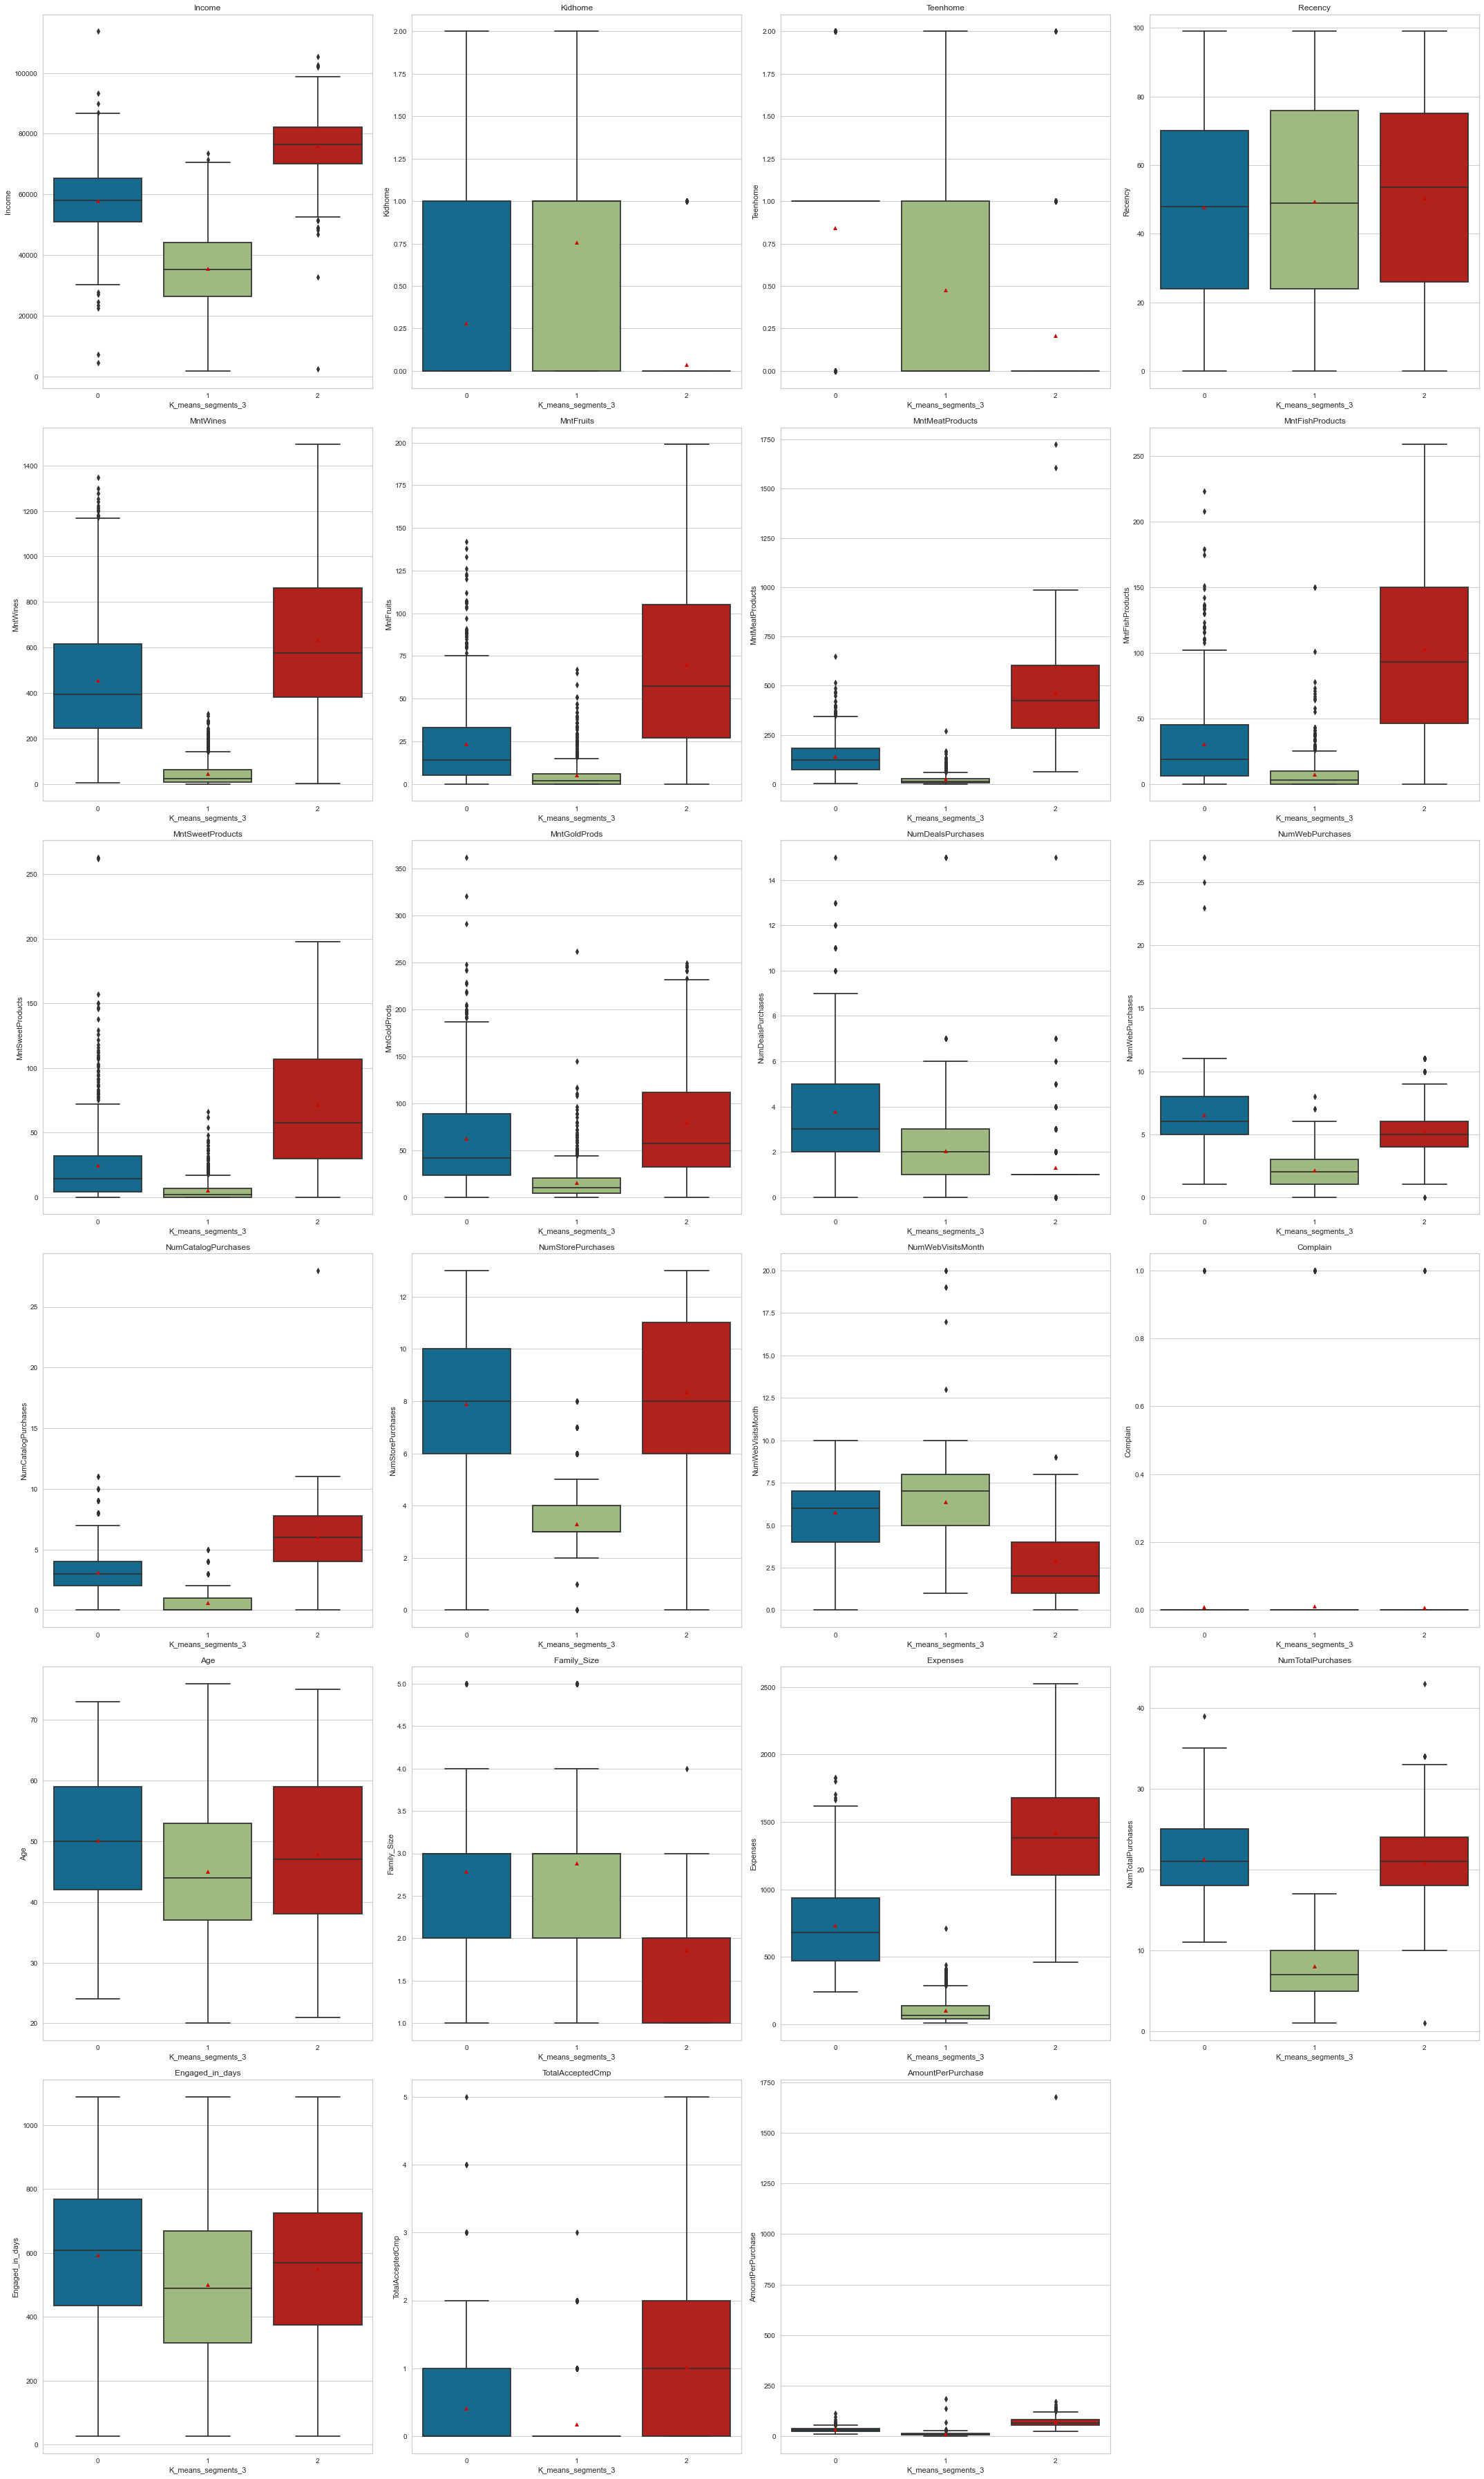

In [21]:
# Creating boxplot for each of the variables
all_col = col_for_box

plt.figure(figsize = (30, 50))

for i, variable in enumerate(all_col):
    plt.subplot(6, 4, i + 1)
    
    sns.boxplot(y=data[variable], x=data['K_means_segments_3'],showmeans=True)
    
    plt.tight_layout()
    
    plt.title(variable)

plt.show()

### **Characteristics of each cluster:**



**Cluster 0: Medium-Income Customers**





**Cluster 1: Low-Income Customers**





**Cluster 2: High-Income Customers** 



**Think About It:**
- Are the K-Means profiles with K=3 providing any deep insights into customer purchasing behavior or which channels they are using?
- What is the next step to get more meaningful insights? 

We can see from the above profiles that K=3 segments the customers into High, Medium and Low-income customers, and we are not getting deep insights into different types of customers. So, let's try to build K=5 (which has another elbow in the Elbow curve) and see if we can get better cluster profiles.

In [22]:
# Dropping labels we got from K=3 since we will be using PCA data for prediction
# Drop K_means_segments_3. Hint: Use axis=1 and inplace=True
data_pca.drop(['K_means_segments_3'], axis=1, inplace=True)
data.drop(['K_means_segments_3'], axis=1, inplace=True)

**Let's build K-Means using K=5**

In [23]:
# Fit the K-Means algorithm using number of cluster as 5 and random_state=0 on data_pca
kmeans = KMeans(n_clusters = 5, random_state = 0)                                # Initialize the K-Means algorithm with 5 clusters and random_state=0

kmeans.fit(data_pca) 

KMeans(n_clusters=5, random_state=0)

In [24]:
# Add K-Means cluster labels to data_pca
data_pca["K_means_segments_5"] = kmeans.labels_ 

# Add K-Means cluster labels to whole data
data["K_means_segments_5"] = kmeans.labels_ 

# Add K-Means cluster labels to data_model
data_model["K_means_segments_5"] = kmeans.labels_ 

In [25]:
# Let's check the distribution
data_model["K_means_segments_5"].value_counts()

3    990
2    401
1    348
0    330
4    158
Name: K_means_segments_5, dtype: int64

**Let's visualize the clusters using PCA**

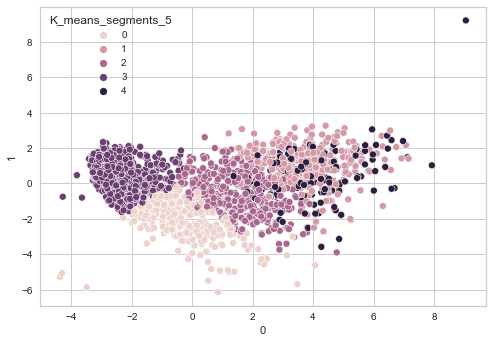

In [26]:
# Hint: Use PCA_PLOT function created above
def PCA_PLOT(X, Y, PCA, cluster):
    sns.scatterplot(x=X, y=Y, data=PCA, hue=cluster)
    
PCA_PLOT(data_pca[0], data_pca[1], data_pca, "K_means_segments_5")

### **Cluster Profiling**

In [27]:
# Take the cluster-wise mean of all the variables. Hint: First groupby 'data' by cluster labels column and then find mean
cluster_profile_KMeans_5 = data.groupby('K_means_segments_5').mean()

In [28]:
# Highlight the maximum average value among all the clusters for each of the variables
cluster_profile_KMeans_5.style.highlight_max(color="lightgreen", axis=0)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Kids,Status,Family_Size,Expenses,NumTotalPurchases,Engaged_in_days,TotalAcceptedCmp,AmountPerPurchase
K_means_segments_5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1966.578788,49125.236364,0.554545,0.860606,48.721212,336.660606,10.703030,91.987879,17.651515,13.057576,53.433333,5.233333,6.051515,2.142424,5.966667,7.187879,0.103030,0.136364,0.003030,0.030303,0.012121,0.006061,0.206061,49.421212,1.415152,1.663636,3.078788,523.493939,19.393939,657.257576,0.490909,26.313403
1,1967.508621,74739.373563,0.020115,0.204023,51.172414,523.074713,82.655172,478.250000,120.695402,81.074713,86.500000,1.356322,4.873563,6.034483,8.341954,2.571839,0.031609,0.031609,0.109195,0.112069,0.000000,0.000000,0.152299,48.491379,0.224138,1.617816,1.841954,1372.250000,20.606322,534.241379,0.436782,69.066125
2,1965.820449,64094.630923,0.109726,0.715711,47.197007,493.064838,35.169576,193.860349,45.104738,35.386534,64.229426,2.366584,6.319202,3.937656,9.044888,4.413965,0.044888,0.074813,0.022444,0.037406,0.002494,0.014963,0.054863,50.179551,0.825436,1.648379,2.473815,866.815461,21.668329,538.506234,0.236908,40.429423
3,1971.235354,34941.218182,0.755556,0.462626,49.328283,39.046465,4.774747,20.687879,6.886869,4.977778,14.246465,1.849495,1.998990,0.519192,3.224242,6.297980,0.061616,0.013131,0.000000,0.001010,0.002020,0.011111,0.077778,44.764646,1.218182,1.651515,2.869697,90.620202,7.591919,490.511111,0.155556,10.821704
4,1969.835443,79338.816456,0.050633,0.196203,48.955696,951.386076,48.120253,464.620253,70.708861,56.341772,67.917722,1.215190,5.905063,6.183544,8.006329,3.734177,0.246835,0.430380,0.721519,0.500000,0.139241,0.006329,0.721519,46.164557,0.246835,1.613924,1.860759,1659.094937,21.310127,596.481013,2.759494,91.504296


**Let's plot the boxplot**

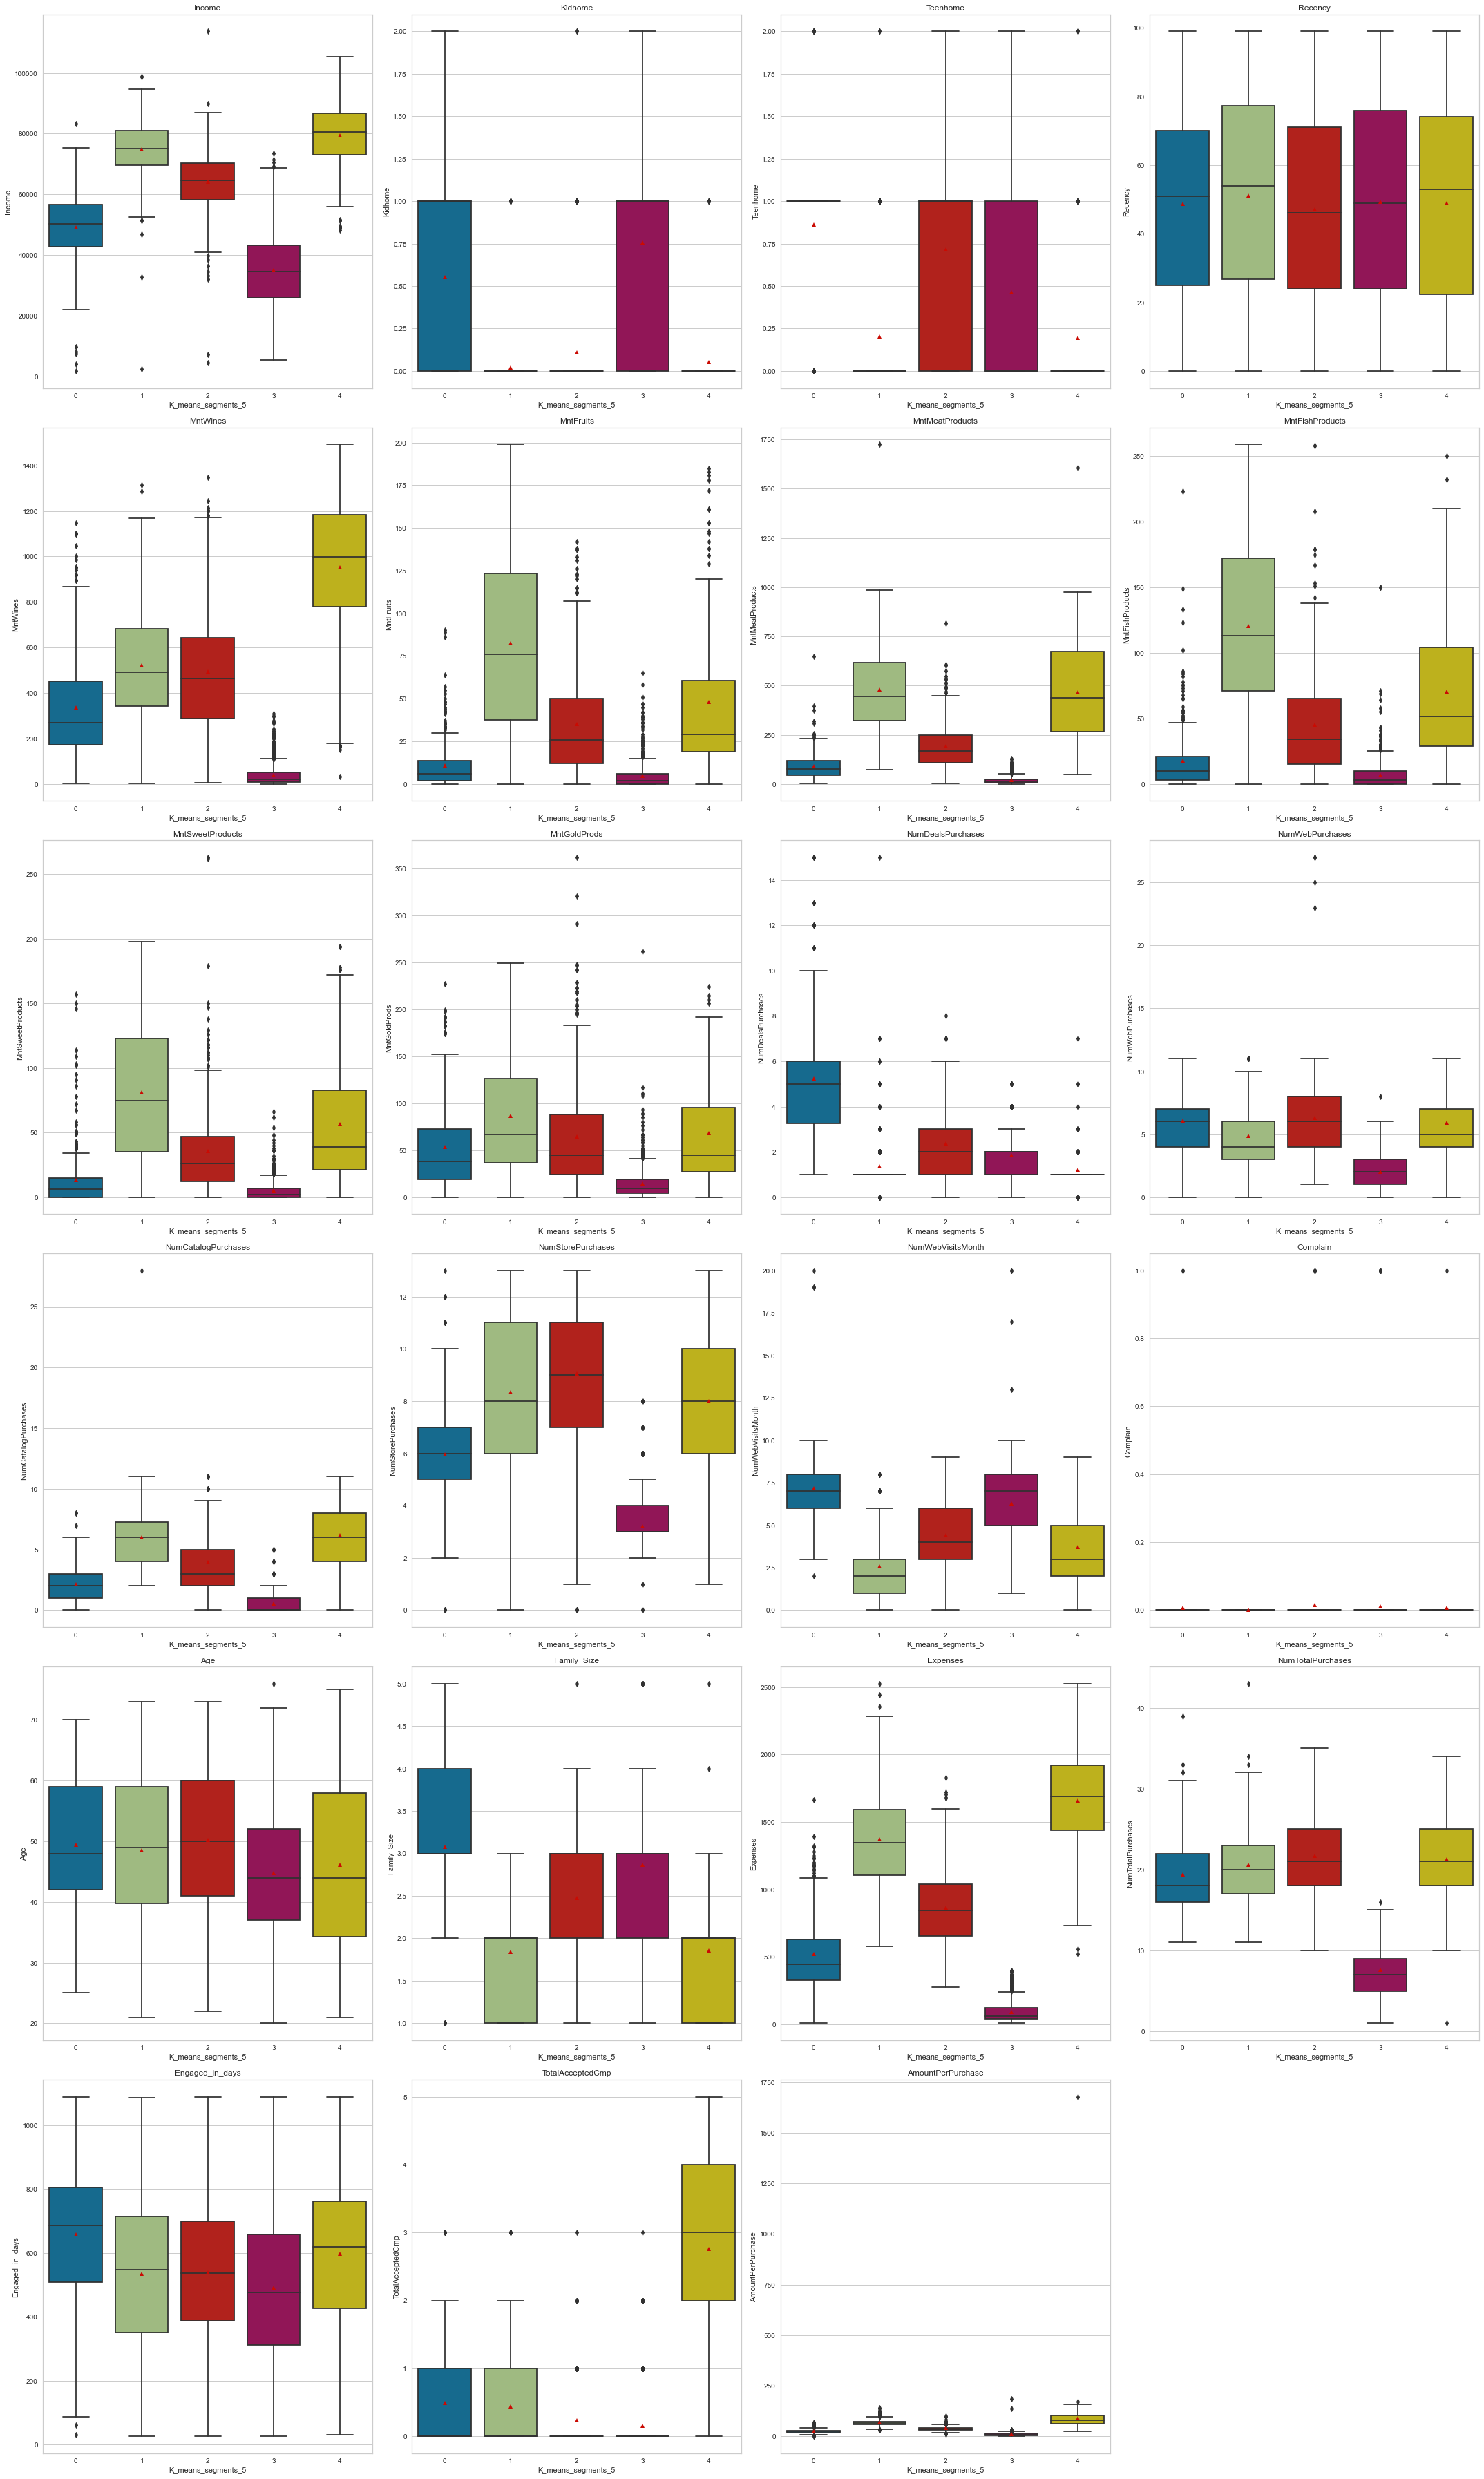

In [29]:
# Create boxplot for each of the variables
col_for_box = ['Income','Kidhome','Teenhome','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Complain','Age','Family_Size','Expenses','NumTotalPurchases','Engaged_in_days','TotalAcceptedCmp','AmountPerPurchase']

all_col = col_for_box

plt.figure(figsize = (30, 50))

for i, variable in enumerate(all_col):
    plt.subplot(6, 4, i + 1)
    
    sns.boxplot(y=data[variable], x=data['K_means_segments_5'],showmeans=True)
    
    plt.tight_layout()
    
    plt.title(variable)

plt.show()

### **Characteristics of each cluster**

**Cluster 0: Middle/Low-Income Customers with Kids**


**Cluster 1: High-Income Customers who don't have kids and spend a more modestly**


**Cluster 2: Middle-Income Customers** 


**Cluster 3: Low-Income Customers** 


**Cluster 4: High-Income Customers who don't have kids and spend a lot** 

In [30]:
# Dropping labels we got from K-Means since we will be using PCA data for prediction
# Hint: Use axis=1 and inplace=True
data_pca.drop(['K_means_segments_5'], axis=1, inplace=True)
data.drop(['K_means_segments_5'], axis=1, inplace=True)

From the above profiles, K=5 provides more interesting insights about customer's purchasing behavior and preferred channels for purchasing products. We can also see that the High, Medium and Low income groups have different age groups and preferences, which was not evident in K=3. So, **we can choose K=5.**

## **K-Medoids**

**Let's find the silhouette score for K=5 in K-Medoids**

In [31]:
kmedo = KMedoids(n_clusters = 5, random_state = 1)           # Initializing K-Medoids with number of clusters as 5 and random_state=1

preds = kmedo.fit_predict(data_pca)            # Fit and predict K-Medoids using data_pca

score = silhouette_score(data_pca, preds)           # Calculate the silhouette score

print(score)                   # Print the score

0.107528069592116


In [32]:
# Predicting on data_pca and ddding K-Medoids cluster labels to the whole data
data["KMed_segments"] = kmedo.fit_predict(data_pca) 

# Predicting on data_pca and ddding K-Medoids cluster labels to data_model
data_model["KMed_segments"] = kmedo.fit_predict(data_pca) 

# Predicting on data_pca and ddding K-Medoids cluster labels to data_pca
data_pca["KMed_segments"] = kmedo.fit_predict(data_pca) 

In [33]:
# Let's check the distribution
data_model["KMed_segments"].value_counts()

3    631
1    578
0    480
2    276
4    262
Name: KMed_segments, dtype: int64

**Let's visualize the clusters using PCA**

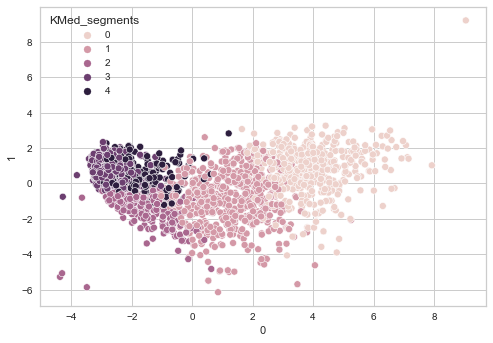

In [34]:
# Hint: Use PCA_PLOT function created above
def PCA_PLOT(X, Y, PCA, cluster):
    sns.scatterplot(x=X, y=Y, data=PCA, hue=cluster)
    
PCA_PLOT(data_pca[0], data_pca[1], data_pca, "KMed_segments")

### **Cluster Profiling**

In [35]:
# Take the cluster-wise mean of all the variables. Hint: First group 'data' by cluster labels column and then find mean
kmed_cluster_profile = data.groupby('KMed_segments').mean()

In [36]:
# Highlight the maximum average value among all the clusters for each of the variables
kmed_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Kids,Status,Family_Size,Expenses,NumTotalPurchases,Engaged_in_days,TotalAcceptedCmp,AmountPerPurchase
KMed_segments,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1968.620833,76228.550000,0.043750,0.220833,50.693750,657.135417,75.320833,479.906250,109.112500,79.768750,82.891667,1.389583,5.497917,5.904167,8.560417,3.087500,0.089583,0.131250,0.283333,0.231250,0.029167,0.004167,0.325000,47.379167,0.264583,1.608333,1.872917,1484.135417,21.352083,567.108333,1.089583,75.798176
1,1965.595156,61872.202422,0.174740,0.737024,46.278547,499.551903,27.456747,179.974048,37.503460,27.005190,63.493080,3.114187,6.150519,3.896194,8.242215,4.875433,0.070934,0.133218,0.043253,0.044983,0.020761,0.010381,0.110727,50.404844,0.911765,1.662630,2.574394,834.984429,21.403114,565.323529,0.423875,39.973157
2,1969.721014,38367.039855,0.782609,0.652174,46.083333,133.579710,8.050725,55.445652,13.050725,7.931159,36.826087,4.268116,4.268116,1.184783,4.195652,7.746377,0.065217,0.047101,0.000000,0.018116,0.003623,0.014493,0.221014,46.278986,1.434783,1.597826,3.032609,254.884058,13.916667,711.858696,0.355072,18.235851
3,1972.343899,33036.182250,0.801902,0.416799,39.255151,24.375594,3.473851,14.274168,5.187005,3.467512,10.407290,1.565769,1.657686,0.316957,2.896989,6.543582,0.083994,0.004754,0.000000,0.000000,0.003170,0.012678,0.083994,43.656101,1.218700,1.646593,2.865293,61.185420,6.437401,475.879556,0.175911,8.746105
4,1967.446565,42988.339695,0.557252,0.595420,79.431298,89.339695,8.744275,37.122137,11.366412,8.656489,19.496183,2.053435,2.751908,1.007634,4.187023,4.942748,0.030534,0.041985,0.003817,0.007634,0.000000,0.000000,0.000000,48.553435,1.152672,1.717557,2.870229,174.725191,10.000000,392.671756,0.083969,15.504972


**Let's plot the boxplot**

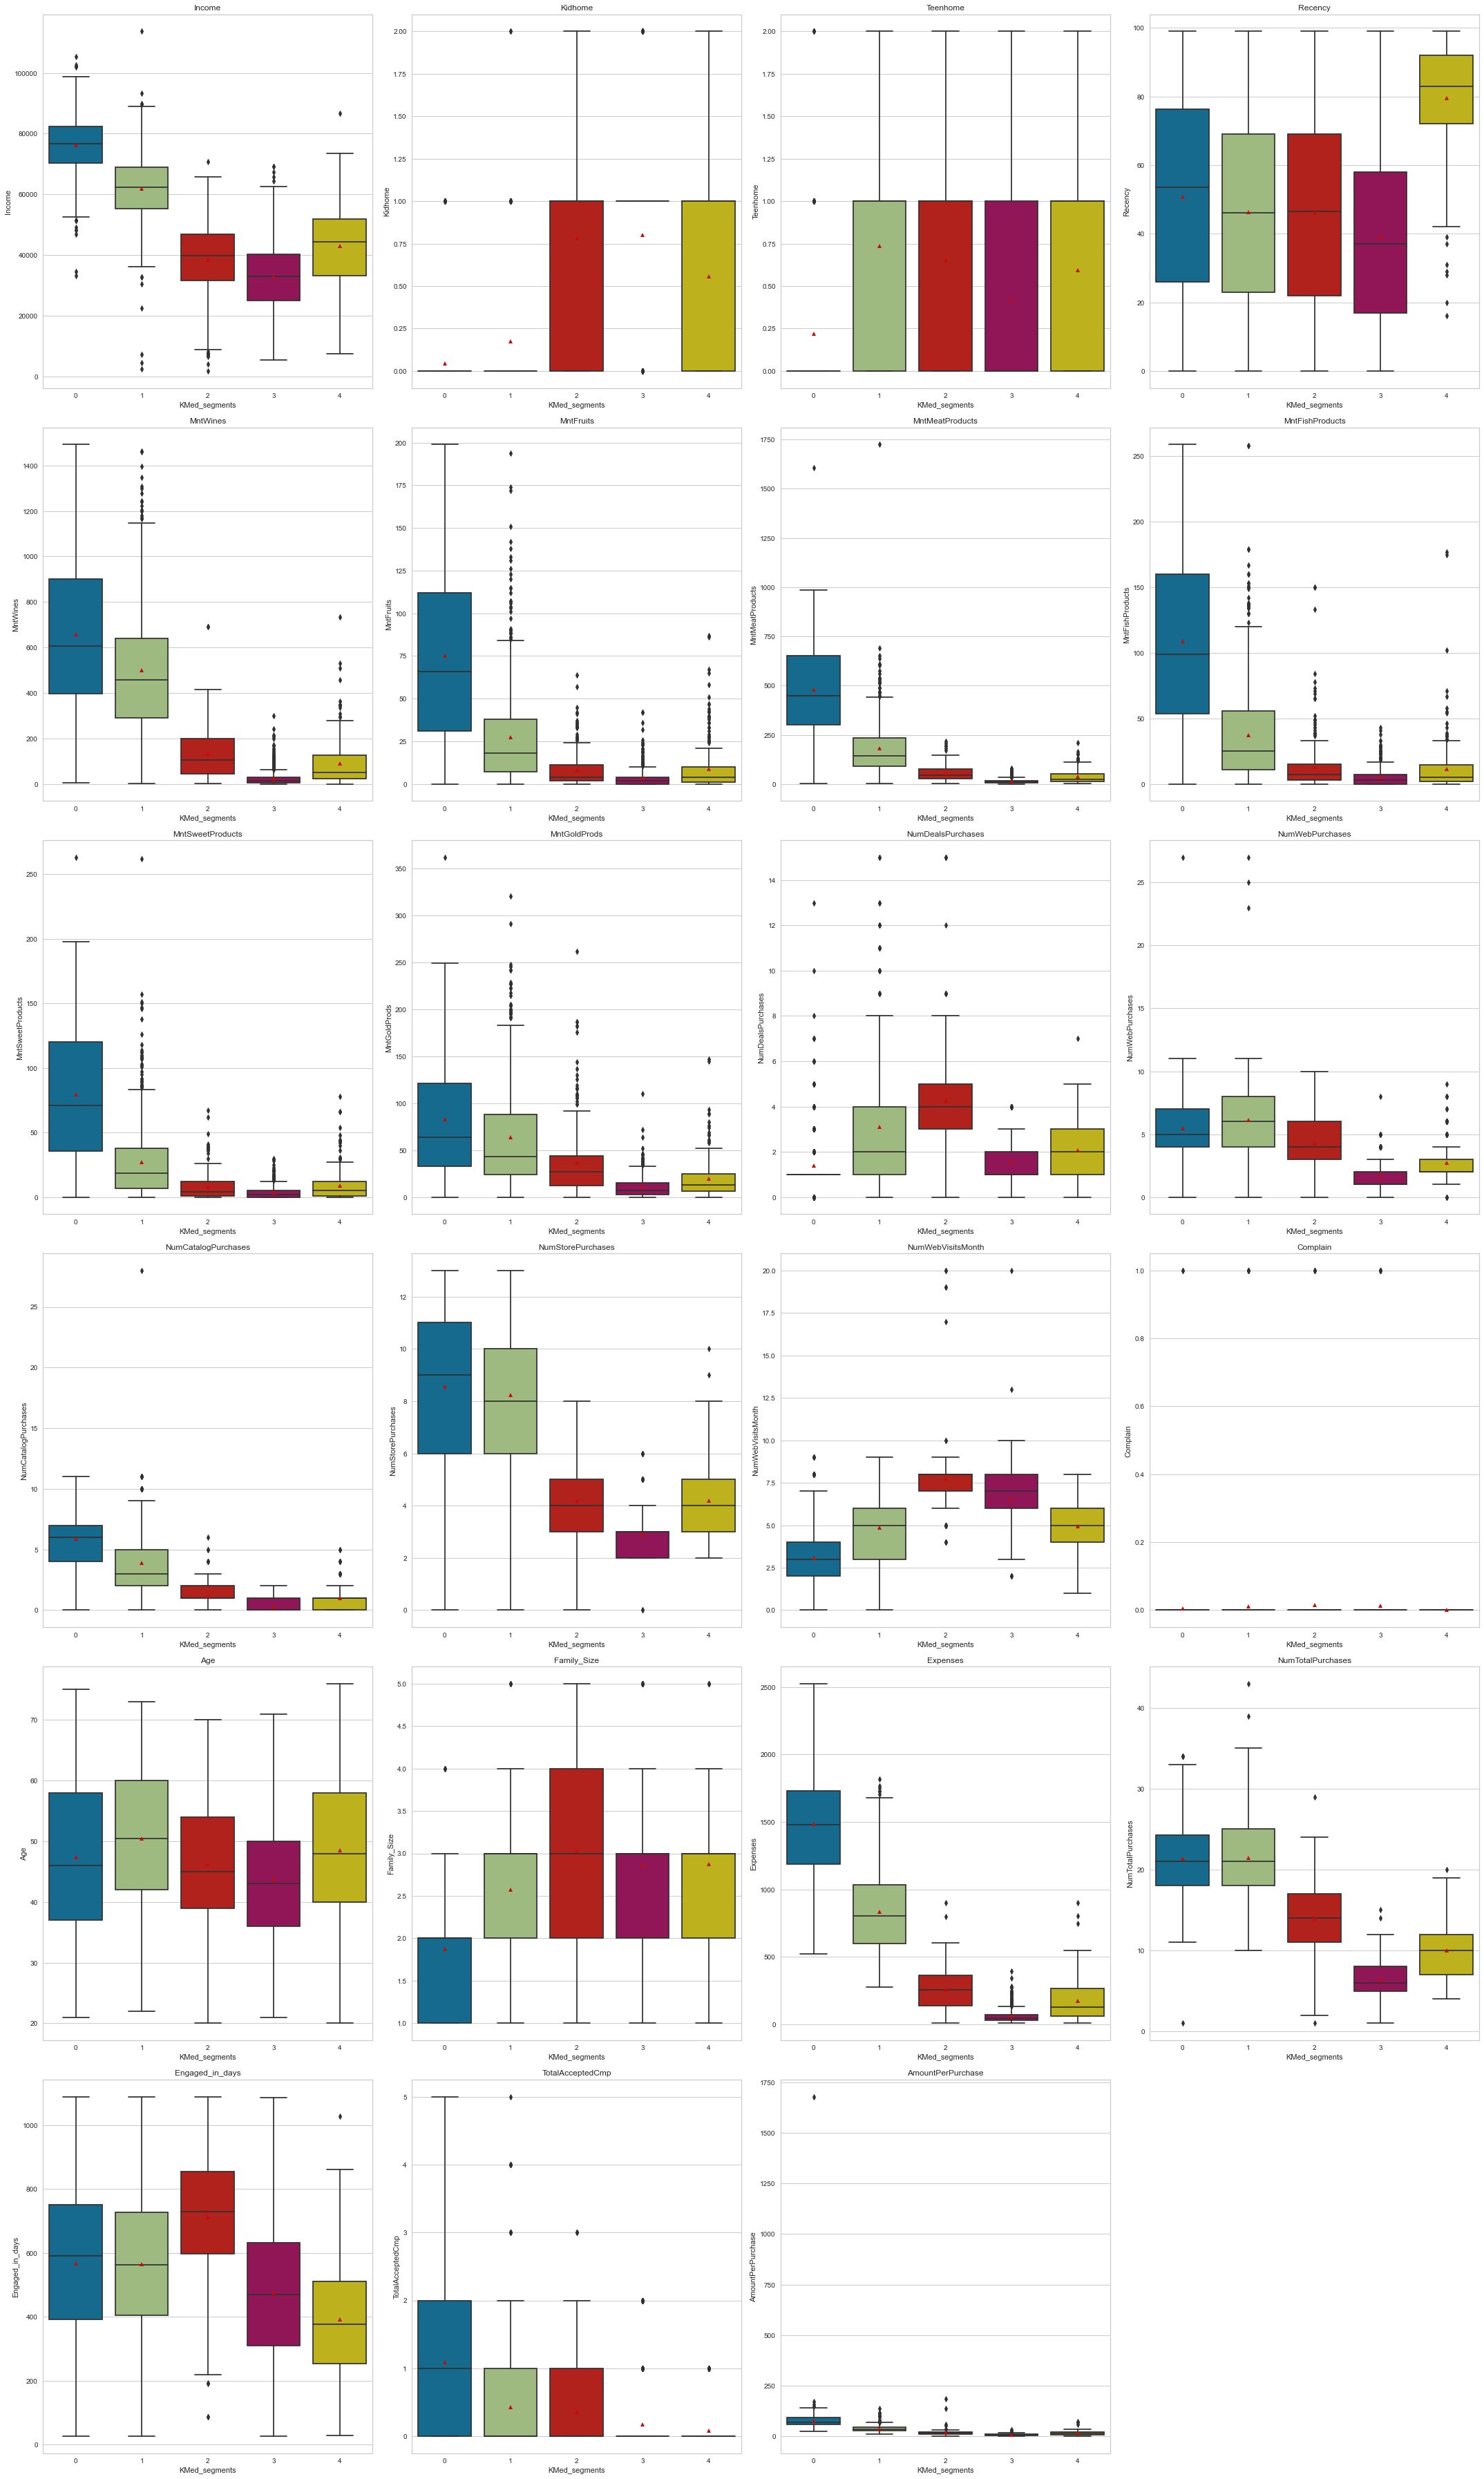

In [37]:
# Create boxplot for each of the variables
col_for_box = ['Income','Kidhome','Teenhome','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Complain','Age','Family_Size','Expenses','NumTotalPurchases','Engaged_in_days','TotalAcceptedCmp','AmountPerPurchase']

all_col = col_for_box

plt.figure(figsize = (30, 50))

for i, variable in enumerate(all_col):
    plt.subplot(6, 4, i + 1)
    
    sns.boxplot(y=data[variable], x=data['KMed_segments'],showmeans=True)
    
    plt.tight_layout()
    
    plt.title(variable)

plt.show()

In [38]:
# Dropping labels we got from K-Medoids since we will be using PCA data for prediction
# Hint: Use axis=1 and inplace=True
data_pca.drop(['KMed_segments'], axis=1, inplace=True)
data.drop(['KMed_segments'], axis=1, inplace=True)

## **Hierarchical Clustering**

Let's find the Cophenetic correlation for different distances with different linkage methods.

### **What is a Cophenetic correlation?**

The cophenetic correlation coefficient is a correlation coefficient between the cophenetic distances(Dendrogramic distance) obtained from the tree, and the original distances used to construct the tree. It is a measure of how faithfully a dendrogram preserves the pairwise distances between the original unmodeled data points. 

The cophenetic distance between two observations is represented in a dendrogram by the height of the link at which those two observations are first joined. That height is the distance between the two subclusters that are merged by that link.

Cophenetic correlation is the way to compare two or more dendrograms. 

**Let's calculate Cophenetic correlation for each of the distance metrics with each of the linkage methods**

In [39]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average"]

high_cophenet_corr = 0                                                 # Creating a variable by assigning 0 to it
high_dm_lm = [0, 0]                                                    # Creating a list by assigning 0's to it

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_pca, metric=dm, method=lm)                    # Applying different linkages with different distance on data_pca
        c, coph_dists = cophenet(Z, pdist(data_pca))                   # Calculating cophenetic correlation
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:                                     # Checking if cophenetic correlation is higher than previous score
            high_cophenet_corr = c                                     # Appending to high_cophenet_corr list if it is higher
            high_dm_lm[0] = dm                                         # Appending its corresponding distance
            high_dm_lm[1] = lm                                         # Appending its corresponding method or linkage

Cophenetic correlation for Euclidean distance and single linkage is 0.8063217204308335.
Cophenetic correlation for Euclidean distance and complete linkage is 0.6171288089817473.
Cophenetic correlation for Euclidean distance and average linkage is 0.8619040295688462.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7884037056391842.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7014009350834748.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8121282710675838.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.6282974517659424.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.4777705960554341.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.6771643207137548.
Cophenetic correlation for Cityblock distance and single linkage is 0.809068704788454.
Cophenetic correlation for Cityblock distance and complete linkage is 0.796343405201907.
Cophenetic correl

In [40]:
# Printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8671371105092277, which is obtained with Cityblock distance and average linkage.


**Let's have a look at the dendrograms for different linkages with `Cityblock distance`**

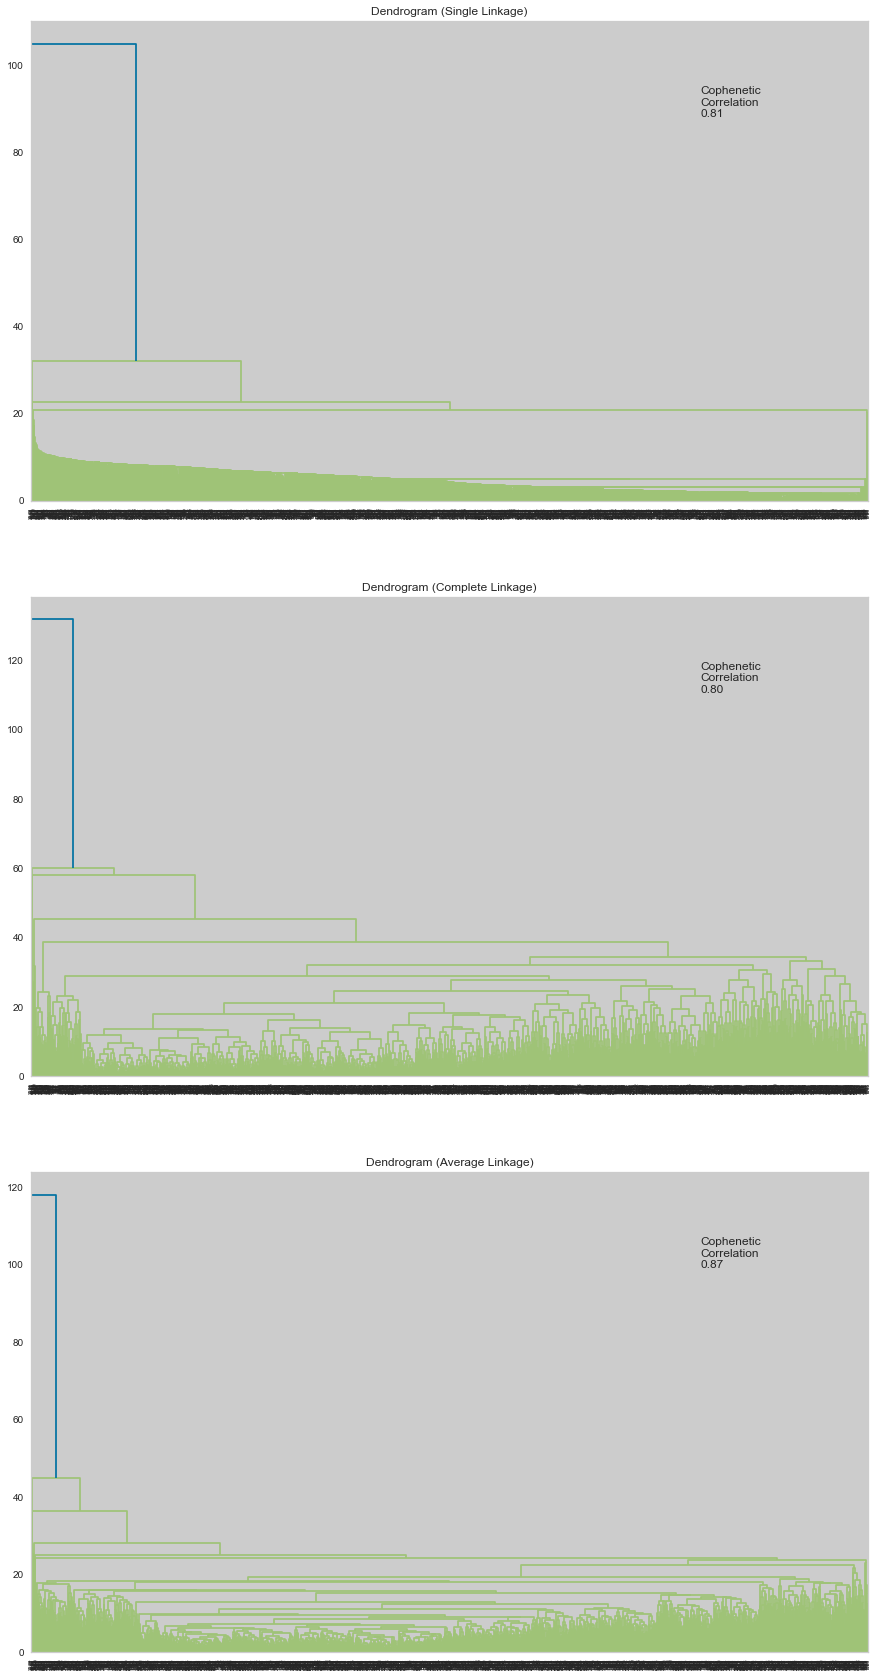

In [41]:
# List of linkage methods
linkage_methods = ["single", "complete", "average"]

# Lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# To create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))            # Setting the plot size

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_pca, metric="Cityblock", method=method)                  # Measures the distances between two clusters

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")           # Title of dendrogram

    coph_corr, coph_dist = cophenet(Z, pdist(data_pca))                       # Finding cophenetic correlation for different linkages with city block distance
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Think about it:**

- Can we clearly decide the number of clusters based on where to cut the dendrogram horizontally?
- What is the next step in obtaining number of clusters based on the dendrogram?

**Let's have a look at the dendrograms for different linkages with `Chebyshev distance`**

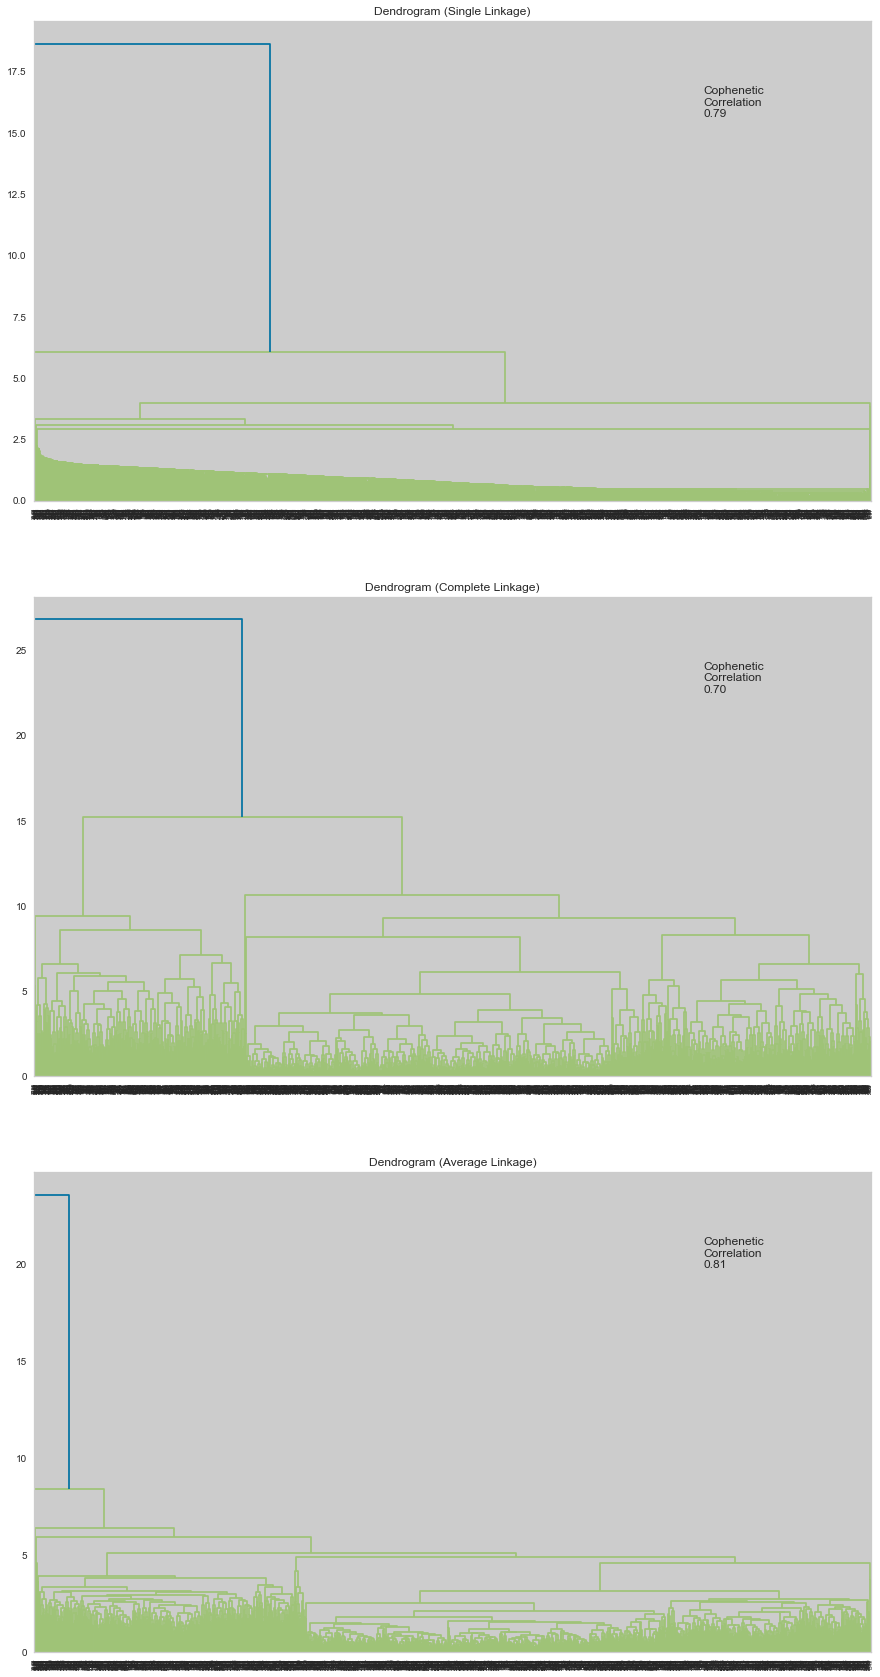

In [42]:
# Plot the dendrogram for Chebyshev distance with linkages single, complete and average. 
# Hint: Use Chebyshev distance as the metric in the linkage() function 
# List of linkage methods
linkage_methods = ["single", "complete", "average"]

# Lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# To create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))            # Setting the plot size

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_pca, metric="Chebyshev", method=method)                  # Measures the distances between two clusters

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")           # Title of dendrogram

    coph_corr, coph_dist = cophenet(Z, pdist(data_pca))                       # Finding cophenetic correlation for different linkages with chevbyshev block distance
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Let's have a look at the dendrograms for different linkages with Mahalanobis distance**

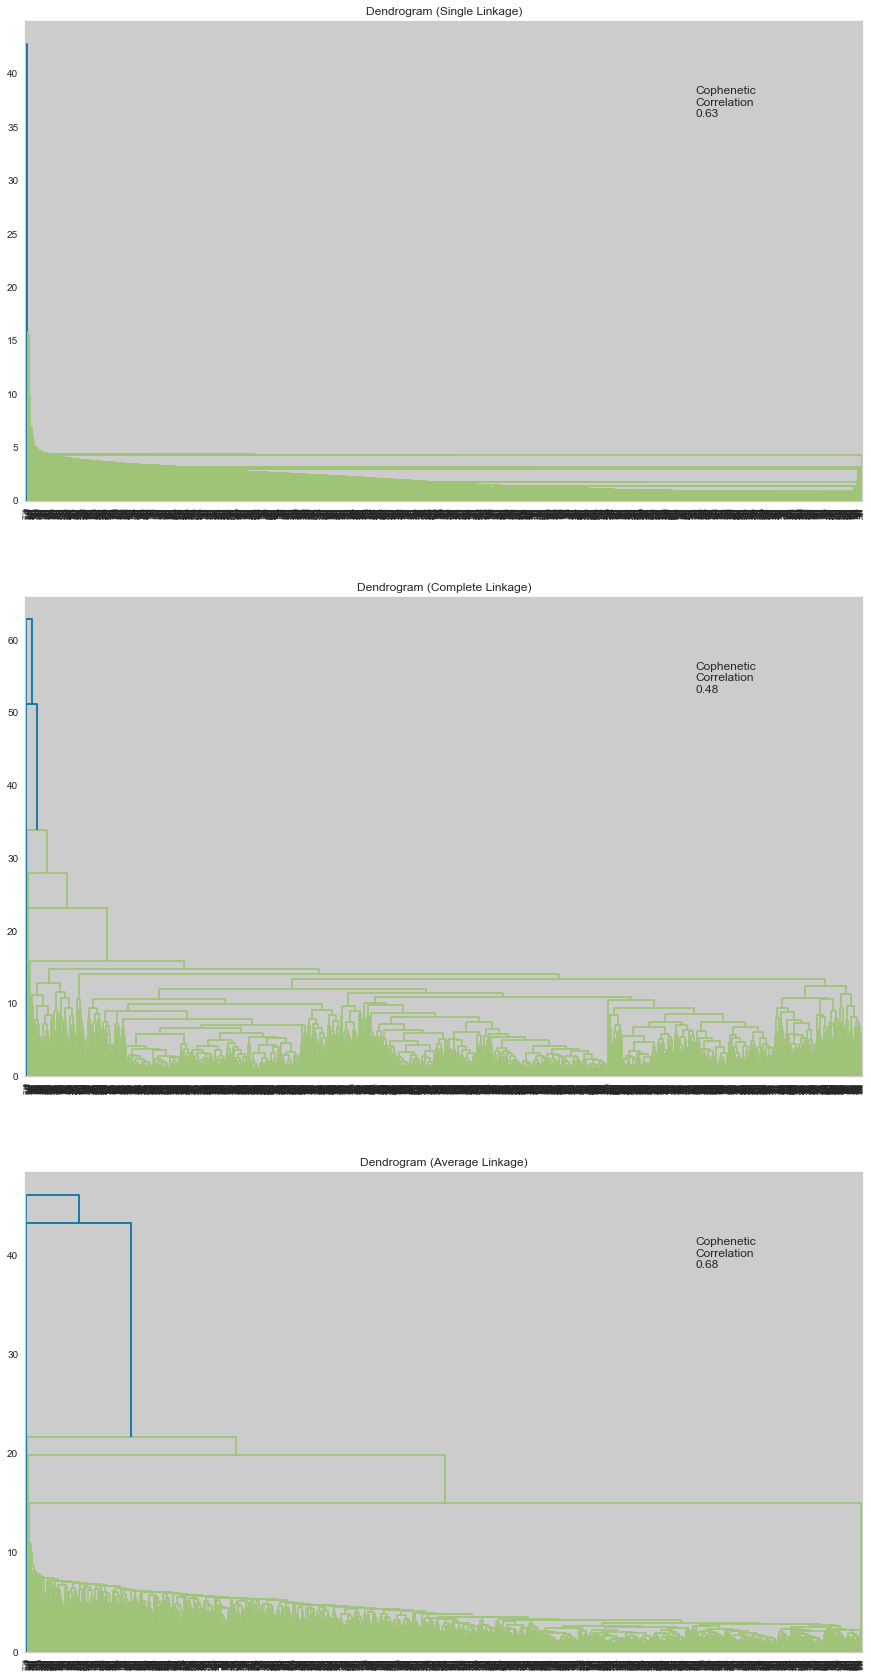

In [43]:
# Plot the dendrogram for Mahalanobis distance with linkages single, complete and average. 
# Hint: Use Mahalanobis distance as the metric in the linkage() function 
# List of linkage methods
linkage_methods = ["single", "complete", "average"]

# Lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# To create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))            # Setting the plot size

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_pca, metric="Mahalanobis", method=method)                  # Measures the distances between two clusters

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")           # Title of dendrogram

    coph_corr, coph_dist = cophenet(Z, pdist(data_pca))                       # Finding cophenetic correlation for different linkages with mahalanobis block distance
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Let's have a look at the dendrograms for different linkages with Euclidean distance**

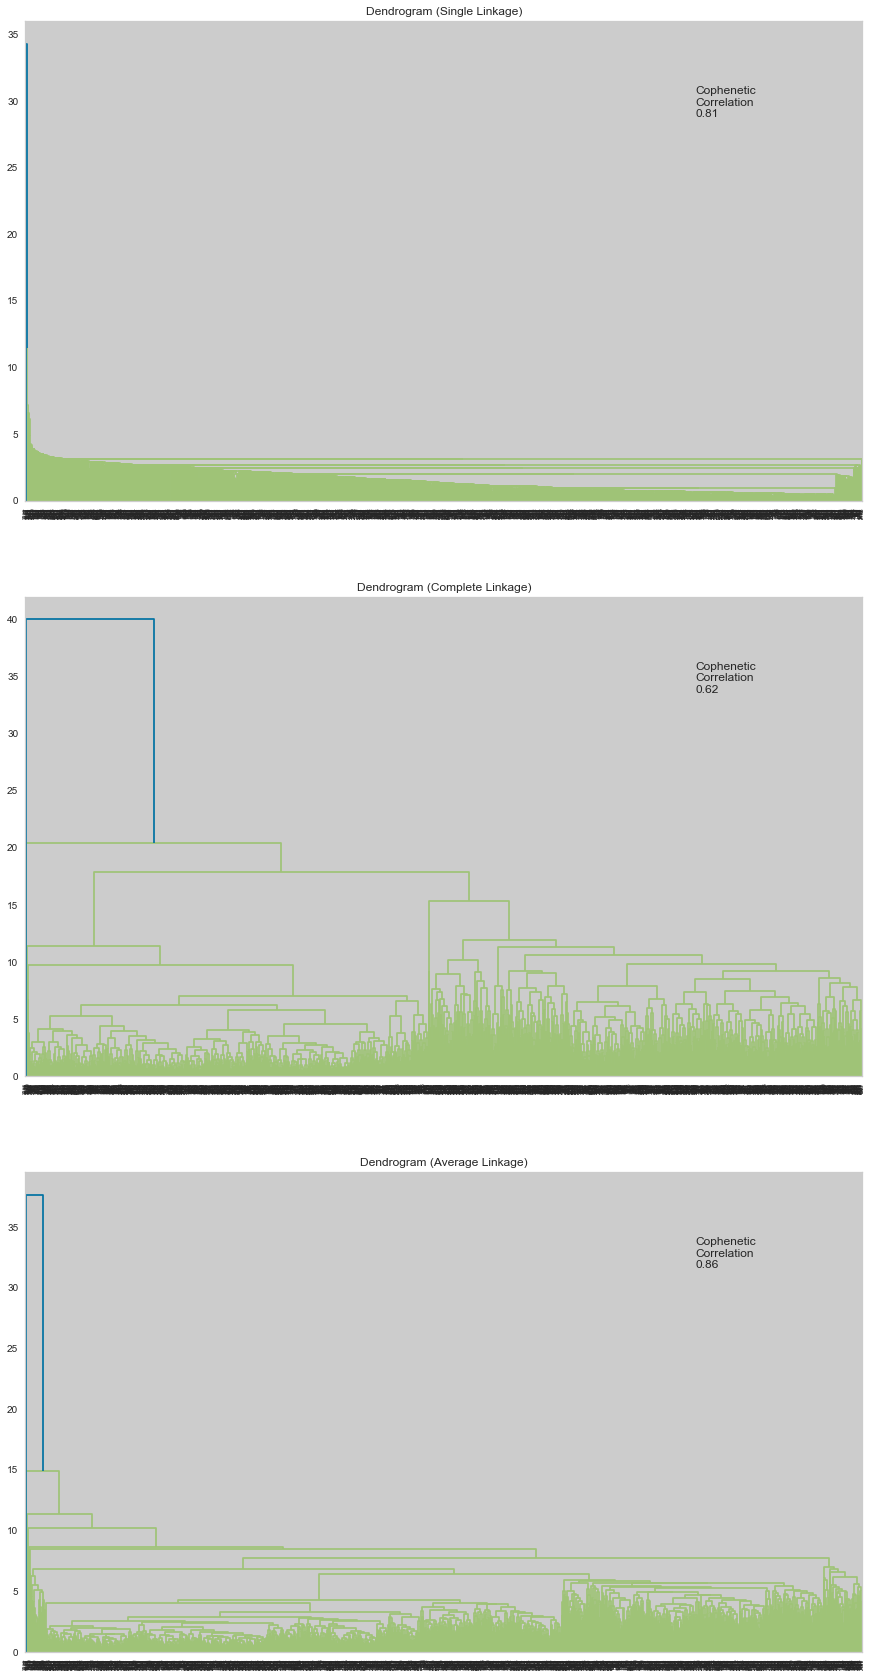

In [44]:
# Plot the dendrogram for Euclidean distance with linkages single, complete, average and ward. 
# Hint: Use Euclidean distance as the metric in the linkage() function 
# List of linkage methods
linkage_methods = ["single", "complete", "average"]

# Lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# To create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))            # Setting the plot size

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_pca, metric="Euclidean", method=method)                  # Measures the distances between two clusters

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")           # Title of dendrogram

    coph_corr, coph_dist = cophenet(Z, pdist(data_pca))                       # Finding cophenetic correlation for different linkages with euclidean block distance
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Think about it:**

- Are there any distinct clusters in any of the dendrograms?

**Observations and Insights:**

In [45]:
# Initialize Agglomerative Clustering with affinity (distance) as Euclidean, linkage as 'Ward' with clusters=3
HCmodel = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward',) 

# Fit on data_pca
HCmodel.fit(data_pca)             

labels = HCmodel.labels_           

score = silhouette_score(data_pca, labels)           # Calculate the silhouette score

print(score) 

0.25378332321341474


In [46]:
# Add Agglomerative Clustering cluster labels to data_pca
data_pca["HC_segments"] = HCmodel.labels_ 

# Add Agglomerative Clustering cluster labels to the whole data
data["HC_segments"] = HCmodel.labels_ 

# Add Agglomerative Clustering cluster labels to data_model
data_model["HC_segments"] = HCmodel.labels_ 

In [47]:
# Let's check the distribution
data_model["HC_segments"].value_counts()

1    1072
0     583
2     572
Name: HC_segments, dtype: int64

**Let's visualize the clusters using PCA.**

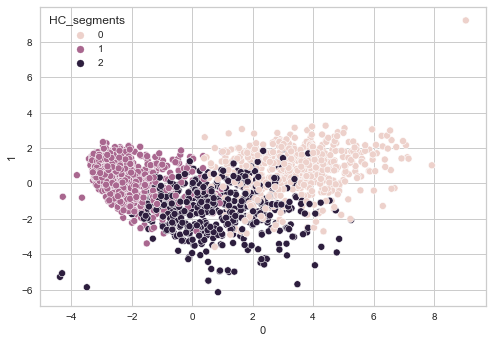

In [48]:
# Hint: Use PCA_PLOT function created above
def PCA_PLOT(X, Y, PCA, cluster):
    sns.scatterplot(x=X, y=Y, data=PCA, hue=cluster)
    
PCA_PLOT(data_pca[0], data_pca[1], data_pca, "HC_segments")

### **Cluster Profiling**

In [49]:
# Take the cluster-wise mean of all the variables. Hint: First group 'data' by cluster labels column and then find mean
hc_cluster_profile = data.groupby('HC_segments').mean()

In [50]:
# Highlight the maximum average value among all the clusters for each of the variables
hc_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Kids,Status,Family_Size,Expenses,NumTotalPurchases,Engaged_in_days,TotalAcceptedCmp,AmountPerPurchase
HC_segments,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1967.840480,74435.612350,0.029160,0.238422,51.413379,615.029160,65.641509,436.615780,96.176672,69.054889,80.161235,1.425386,5.404803,5.732419,8.102916,2.960549,0.089194,0.137221,0.259005,0.216123,0.034305,0.003431,0.288165,48.159520,0.267581,1.602058,1.869640,1362.679245,20.665523,556.689537,1.024014,71.114277
1,1971.041045,35708.220149,0.739739,0.475746,49.695896,47.899254,6.098881,25.866604,9.053172,6.685634,17.035448,1.971082,2.223881,0.634328,3.388060,6.302239,0.067164,0.012127,0.000000,0.000000,0.001866,0.010261,0.083955,44.958955,1.215485,1.646455,2.861940,112.638993,8.217351,507.765858,0.165112,11.807554
2,1965.923077,58347.451049,0.314685,0.842657,45.688811,471.874126,24.339161,150.594406,31.692308,22.931818,58.269231,3.893357,6.300699,3.243007,8.041958,5.909091,0.068182,0.129371,0.019231,0.031469,0.012238,0.012238,0.132867,50.076923,1.157343,1.685315,2.842657,759.701049,21.479021,576.445804,0.393357,34.937898


**Let's plot the boxplot**

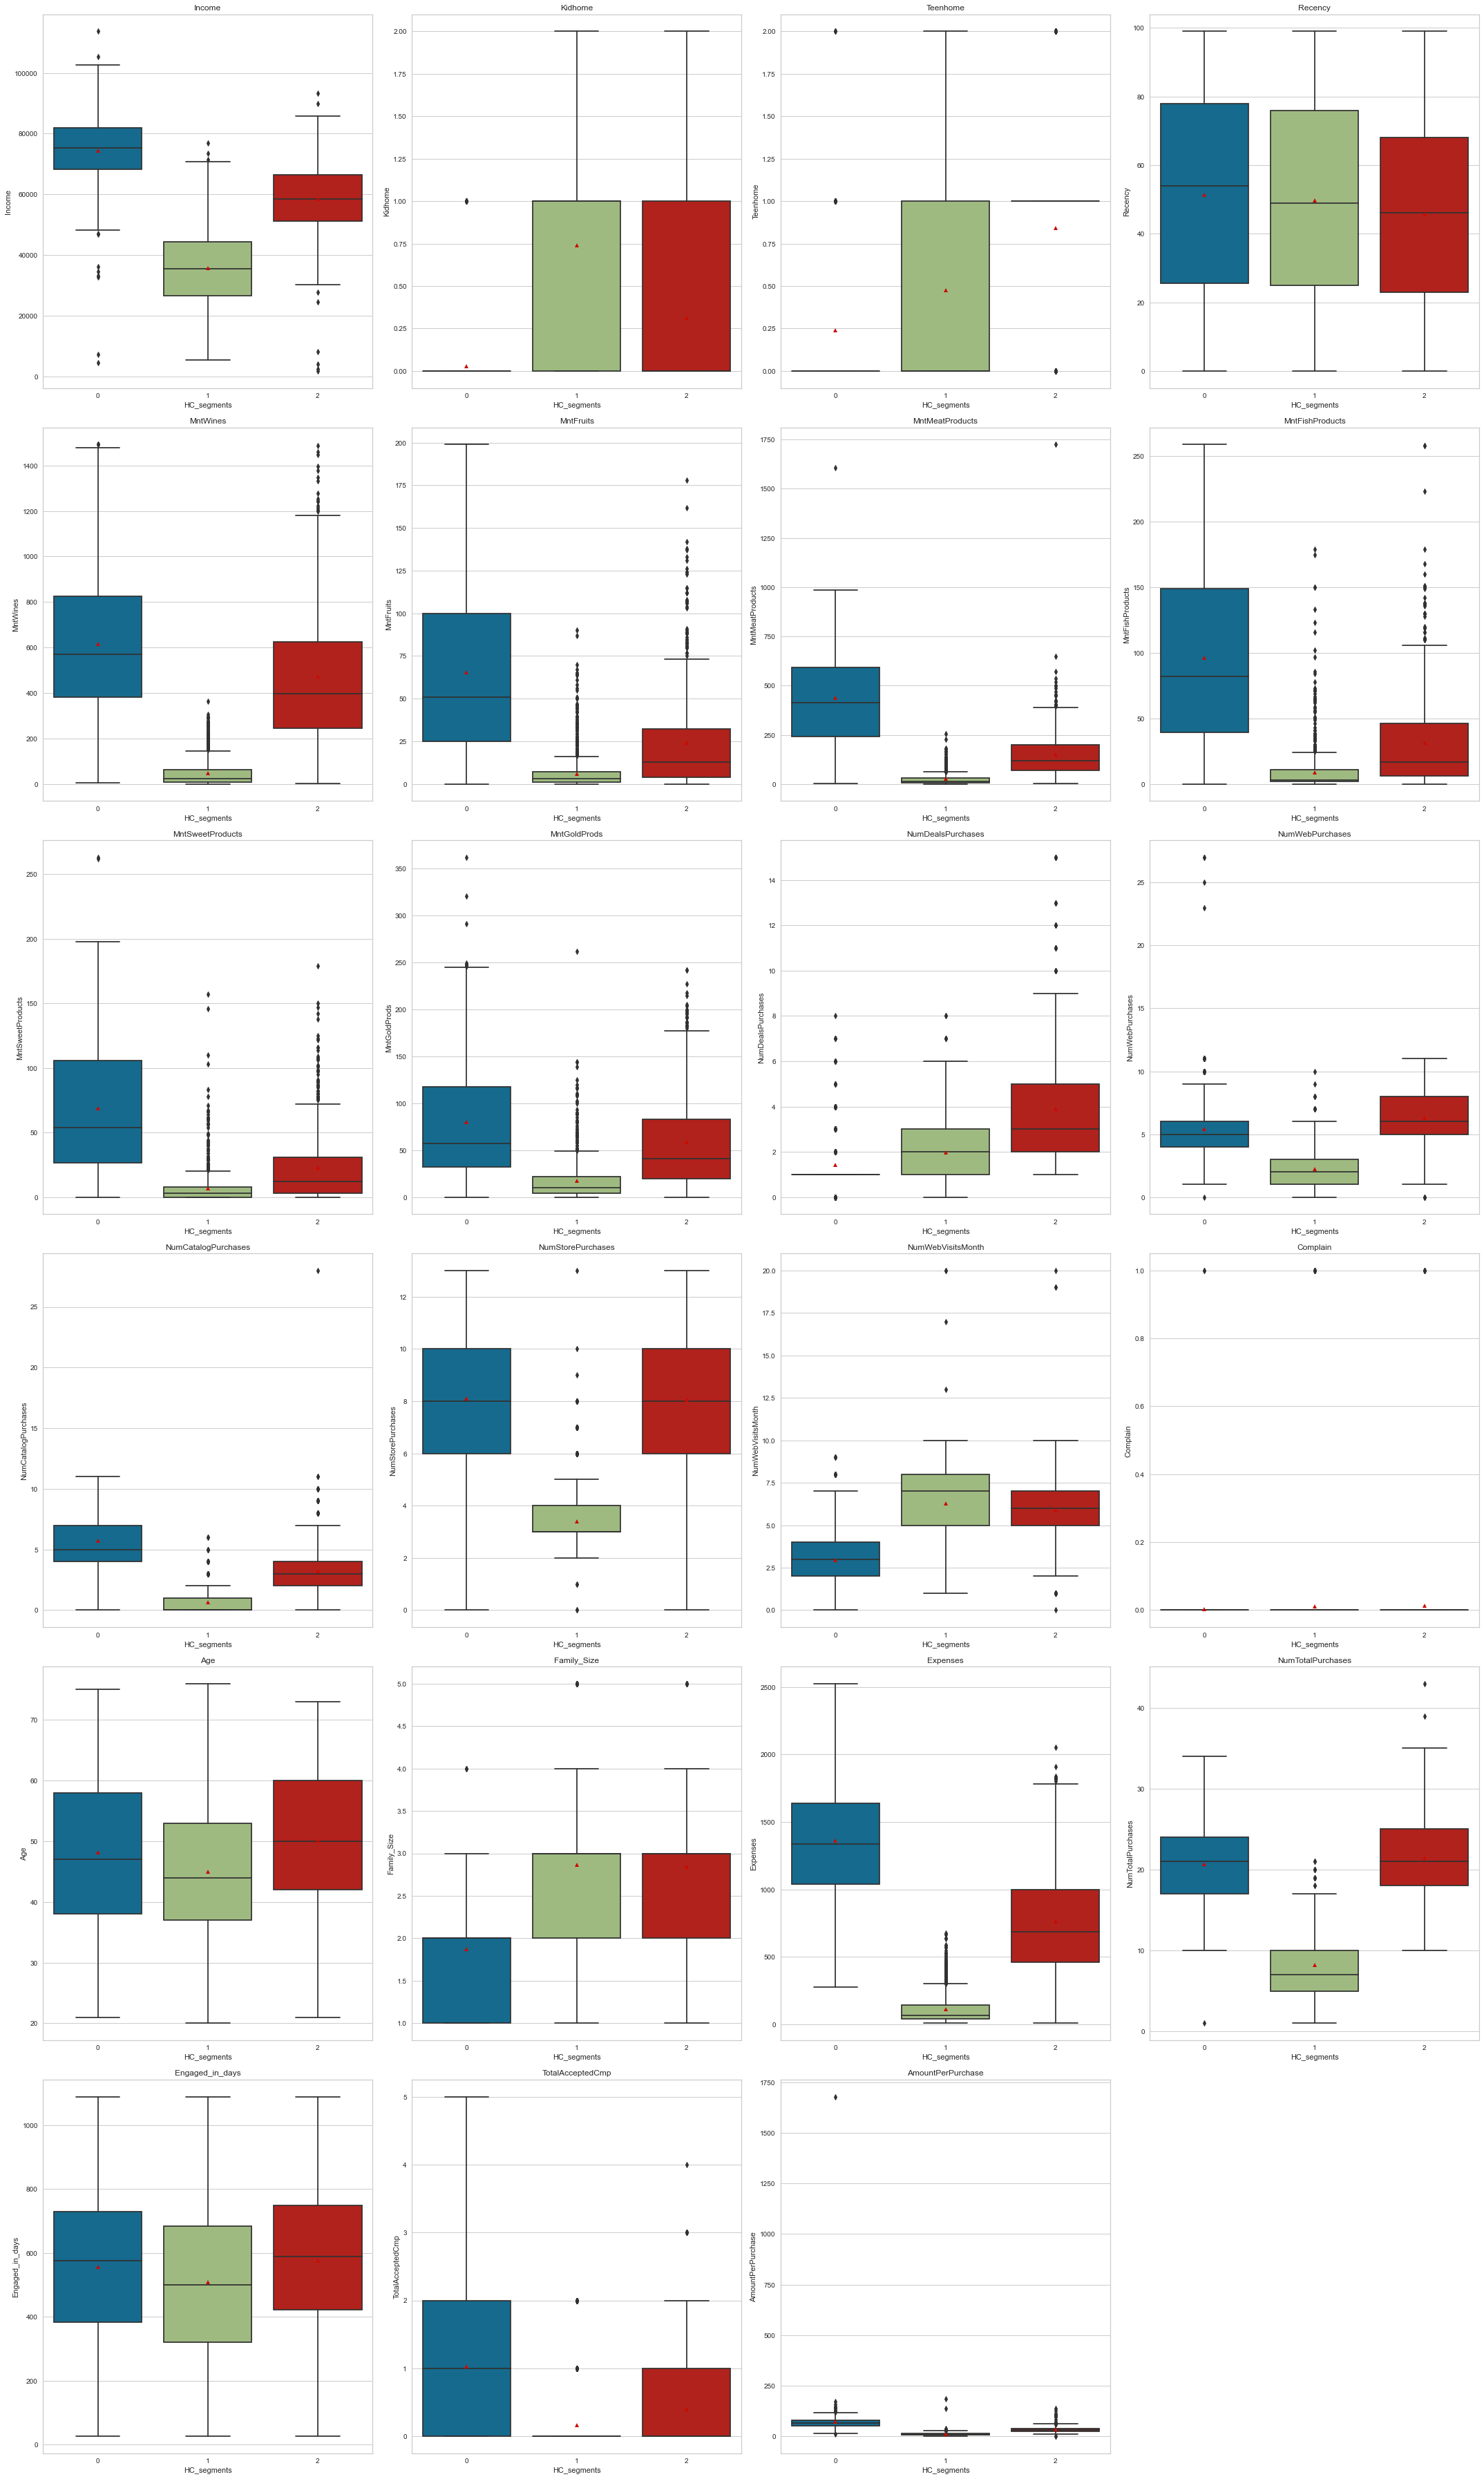

In [51]:
# Create boxplot for each of the variables
col_for_box = ['Income','Kidhome','Teenhome','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Complain','Age','Family_Size','Expenses','NumTotalPurchases','Engaged_in_days','TotalAcceptedCmp','AmountPerPurchase']

all_col = col_for_box

plt.figure(figsize = (30, 50))

for i, variable in enumerate(all_col):
    plt.subplot(6, 4, i + 1)
    
    sns.boxplot(y=data[variable], x=data['HC_segments'],showmeans=True)
    
    plt.tight_layout()
    
    plt.title(variable)

plt.show()

### **Characteristics of each cluster**

**Cluster 0: High-Income Customers**

This cluster is only slightly bigger than cluster 2 and consists of 583 customers. Customers in this group seem to spend a lot and don't tend to make purchases through the company's website or with a discount.  This makes sense since this cluster has an average income of 74435.612350.  The customers in this cluster spends significantly more compared to the other clusters with an average total amount spent of 1362.679245 and average of 71.114277 spent per purchase.  The customers in this group also spend the most on wine, fruit, meat, fish, sweet, and gold products in the last 2 years.  They also have the highest average for purchases made using a catalog or directly in store.  The customers in this cluster have an average age of 48 and don't have kids.  These customers have the highest average for accepting the offers in campaigns 1, 2, 3, 4, 5, and the last campaign. 



**Cluster 1: Low-Income Customers**

This cluster is almost twice as big as the other two clusters with a total of 1072 customers.  Customers in this group don't spend a lot and makes more purchases through the company's website using a discount.  These customers spend the least on average for all the products in this dataset.  The average income for customers in this cluster is 35708.220149.  They spend an average total amount of 112.638993 and only 11.807554 per purchase.  These customers seem to be on the younger side compared to the other two clusters with an average age of about 45 and have a small child in their household.



**Cluster 2: Medium-Income Customers** 

This cluster consists of 572 customers.  Customers in this group spend a medium amount and seem to make the most purchases through the company's website using a discount compared to the customers in the other two clusters.  The average income for this group is 58347.451049.  Customers in this group are generally older as the average age is about 50.  They seem to be in a relationship and have a teenager in the household.  The average amount these customers spend is 759.701049 with an average of 34.937898 per purchase.  Customers in this cluster seem to make the most purchases and have been with the company the longest.

**Observations and Insights:**

In [52]:
# Dropping labels we got from Agglomerative Clustering since we will be using PCA data for prediction
# Hint: Use axis=1 and inplace=True
data_pca.drop(['HC_segments'], axis=1, inplace=True)
data.drop(['HC_segments'], axis=1, inplace=True)

## **DBSCAN**

DBSCAN is a very powerful algorithm for finding high-density clusters, but the problem is determining the best set of hyperparameters to use with it. It includes two hyperparameters, `eps`, and `min samples`.

Since it is an unsupervised algorithm, you have no control over it, unlike a supervised learning algorithm, which allows you to test your algorithm on a validation set. The approach we can follow is basically trying out a bunch of different combinations of values and finding the silhouette score for each of them.

In [53]:
# Initializing lists
eps_value = [2,3]                       # Taking random eps value
min_sample_values = [6,20]              # Taking random min_sample value

# Creating a dictionary for each of the values in eps_value with min_sample_values
res = {eps_value[i]: min_sample_values for i in range(len(eps_value))}  

In [54]:
# Finding the silhouette_score for each of the combinations
high_silhouette_avg = 0                                               # Assigning 0 to the high_silhouette_avg variable
high_i_j = [0, 0]                                                     # Assigning 0's to the high_i_j list
key = res.keys()                                                      # Assigning dictionary keys to a variable called key
for i in key:
    z = res[i]                                                        # Assigning dictionary values of each i to z
    for j in z:
        db = DBSCAN(eps=i, min_samples=j).fit(data_pca)               # Applying DBSCAN to each of the combination in dictionary
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        silhouette_avg = silhouette_score(data_pca, labels)           # Finding silhouette score 
        print( 
            "For eps value =" + str(i),
            "For min sample =" + str(j),
            "The average silhoutte_score is :",
            silhouette_avg,                                          # Printing the silhouette score for each of the combinations
        )
        if high_silhouette_avg < silhouette_avg:                     # If the silhouette score is greater than 0 or the previous score, it will get appended to the high_silhouette_avg list with its combination of i and j              
            high_i_j[0] = i
            high_i_j[1] = j

For eps value =2 For min sample =6 The average silhoutte_score is : 0.19914069883245628
For eps value =2 For min sample =20 The average silhoutte_score is : 0.33891446622335347
For eps value =3 For min sample =6 The average silhoutte_score is : 0.33631692402802216
For eps value =3 For min sample =20 The average silhoutte_score is : 0.3398851568849134


In [55]:
# Printing the highest silhouette score
print(
    "Highest_silhoutte_avg is {} for eps = {} and min sample = {}".format(
        high_silhouette_avg, high_i_j[0], high_i_j[1]
    )
)


Highest_silhoutte_avg is 0 for eps = 3 and min sample = 20


**Now, let's apply DBSCAN using the hyperparameter values we have received above.**

In [56]:
# Apply DBSCAN using the above hyperparameter values
dbs = DBSCAN(eps = 3, min_samples = 20)

In [57]:
# fit_predict on data_pca and add DBSCAN cluster labels to the whole data
data["db_segments"] = dbs.fit_predict(data_pca) 

# fit_predict on data_pca and add DBSCAN cluster labels to data_model
data_model["db_segments"] = dbs.fit_predict(data_pca) 

# fit_predict on data_pca and add DBSCAN cluster labels to data_pca
data_pca["db_segments"] = dbs.fit_predict(data_pca) 

In [58]:
# Let's check the distribution
data_model["db_segments"].value_counts()

 0    1905
-1     322
Name: db_segments, dtype: int64

**Let's visualize the clusters using PCA.**

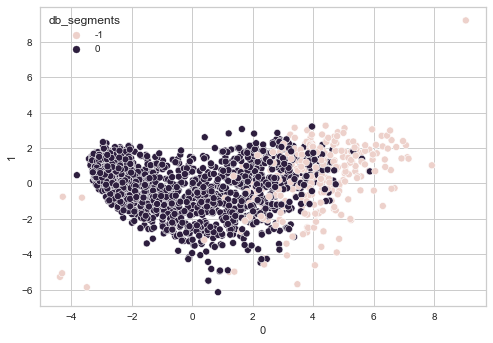

In [59]:
# Hint: Use PCA_PLOT function created above
def PCA_PLOT(X, Y, PCA, cluster):
    sns.scatterplot(x=X, y=Y, data=PCA, hue=cluster)
    
PCA_PLOT(data_pca[0], data_pca[1], data_pca, "db_segments")

**Think about it:**

- Changing the eps and min sample values will result in different DBSCAN results? Can we try more value for eps and min_sample?

**Note:** You can experiment with different eps and min_sample values to see if DBSCAN produces good distribution and cluster profiles.

In [60]:
# Dropping labels we got from DBSCAN since we will be using PCA data for prediction
# Hint: Use axis=1 and inplace=True
data_pca.drop(['db_segments'], axis=1, inplace=True)
data.drop(['db_segments'], axis=1, inplace=True)

## **Gaussian Mixture Model**

**Let's find the silhouette score for K=5 in Gaussian Mixture**

In [61]:
gmm = GaussianMixture(n_components = 5, random_state = 1) # Initialize Gaussian Mixture Model with number of clusters as 5 and random_state=1

preds = gmm.fit_predict(data_pca)            # Fit and predict Gaussian Mixture Model using data_pca

score = silhouette_score(data_pca, preds)           # Calculate the silhouette score

print(score)                   # Print the score

0.14344403792681099


**Observations and Insights:**

In [62]:
# Predicting on data_pca and add Gaussian Mixture Model cluster labels to the whole data
data["GMM_segments"] = gmm.predict(data_pca) 

# Predicting on data_pca and add Gaussian Mixture Model cluster labels to data_model
data_model["GMM_segments"] = gmm.predict(data_pca) 

# Predicting on data_pca and add Gaussian Mixture Model cluster labels to data_pca
data_pca["GMM_segments"] = gmm.predict(data_pca) 

In [63]:
# Let's check the distribution
data_model["GMM_segments"].value_counts()

1    756
4    594
0    446
3    347
2     84
Name: GMM_segments, dtype: int64

**Let's visualize the clusters using PCA.**

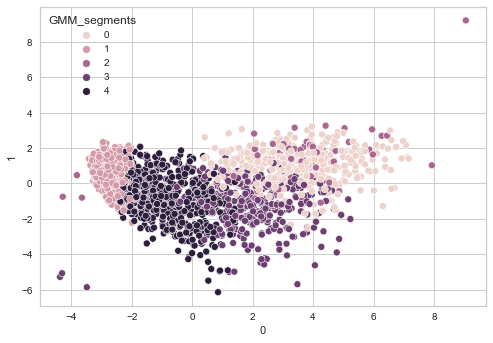

In [64]:
# Hint: Use PCA_PLOT function created above
def PCA_PLOT(X, Y, PCA, cluster):
    sns.scatterplot(x=X, y=Y, data=PCA, hue=cluster)
    
PCA_PLOT(data_pca[0], data_pca[1], data_pca, "GMM_segments")

### **Cluster Profiling**

In [65]:
# Take the cluster-wise mean of all the variables. Hint: First group 'data' by cluster labels column and then find mean
gmm_cluster_profile = data.groupby('GMM_segments').mean()

In [66]:
# Highlight the maximum average value among all the clusters for each of the variables
gmm_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Kids,Status,Family_Size,Expenses,NumTotalPurchases,Engaged_in_days,TotalAcceptedCmp,AmountPerPurchase
GMM_segments,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1967.556054,75558.802691,0.022422,0.204036,51.621076,595.811659,67.056054,460.273543,101.219731,67.802691,76.340807,1.226457,5.168161,5.865471,8.230942,2.486547,0.065022,0.096413,0.219731,0.181614,0.008969,0.004484,0.221973,48.443946,0.226457,1.647982,1.874439,1368.504484,20.491031,520.143498,0.793722,67.444900
1,1972.055556,32101.753968,0.851852,0.443122,48.191799,20.048942,3.068783,12.875661,4.702381,3.287037,10.215608,1.767196,1.632275,0.313492,2.884921,6.403439,0.071429,0.003968,0.000000,0.000000,0.002646,0.013228,0.076720,43.944444,1.294974,1.648148,2.943122,54.198413,6.597884,485.312169,0.154762,7.956939
2,1969.559524,74291.583333,0.130952,0.261905,47.642857,839.440476,59.297619,490.607143,81.392857,57.976190,79.250000,1.238095,3.892857,4.630952,5.630952,4.547619,0.130952,0.345238,0.511905,0.333333,0.119048,0.000000,0.523810,46.440476,0.392857,1.571429,1.964286,1607.964286,15.392857,613.000000,1.964286,123.058593
3,1966.674352,62087.201729,0.170029,0.703170,45.161383,553.299712,42.570605,199.815562,55.374640,47.423631,77.677233,3.340058,6.711816,4.622478,9.253602,5.579251,0.112392,0.123919,0.057637,0.074928,0.031700,0.014409,0.184438,49.325648,0.873199,1.616715,2.489914,976.161383,23.927954,628.948127,0.585014,40.879158
4,1967.057239,49321.569024,0.447811,0.739057,50.930976,229.671717,11.361953,72.143098,15.409091,10.929293,38.626263,3.409091,4.956229,1.735690,5.757576,6.050505,0.050505,0.082492,0.001684,0.015152,0.003367,0.005051,0.116162,48.942761,1.186869,1.664983,2.851852,378.141414,15.858586,555.530303,0.269360,22.700233


**Let's plot the boxplot**

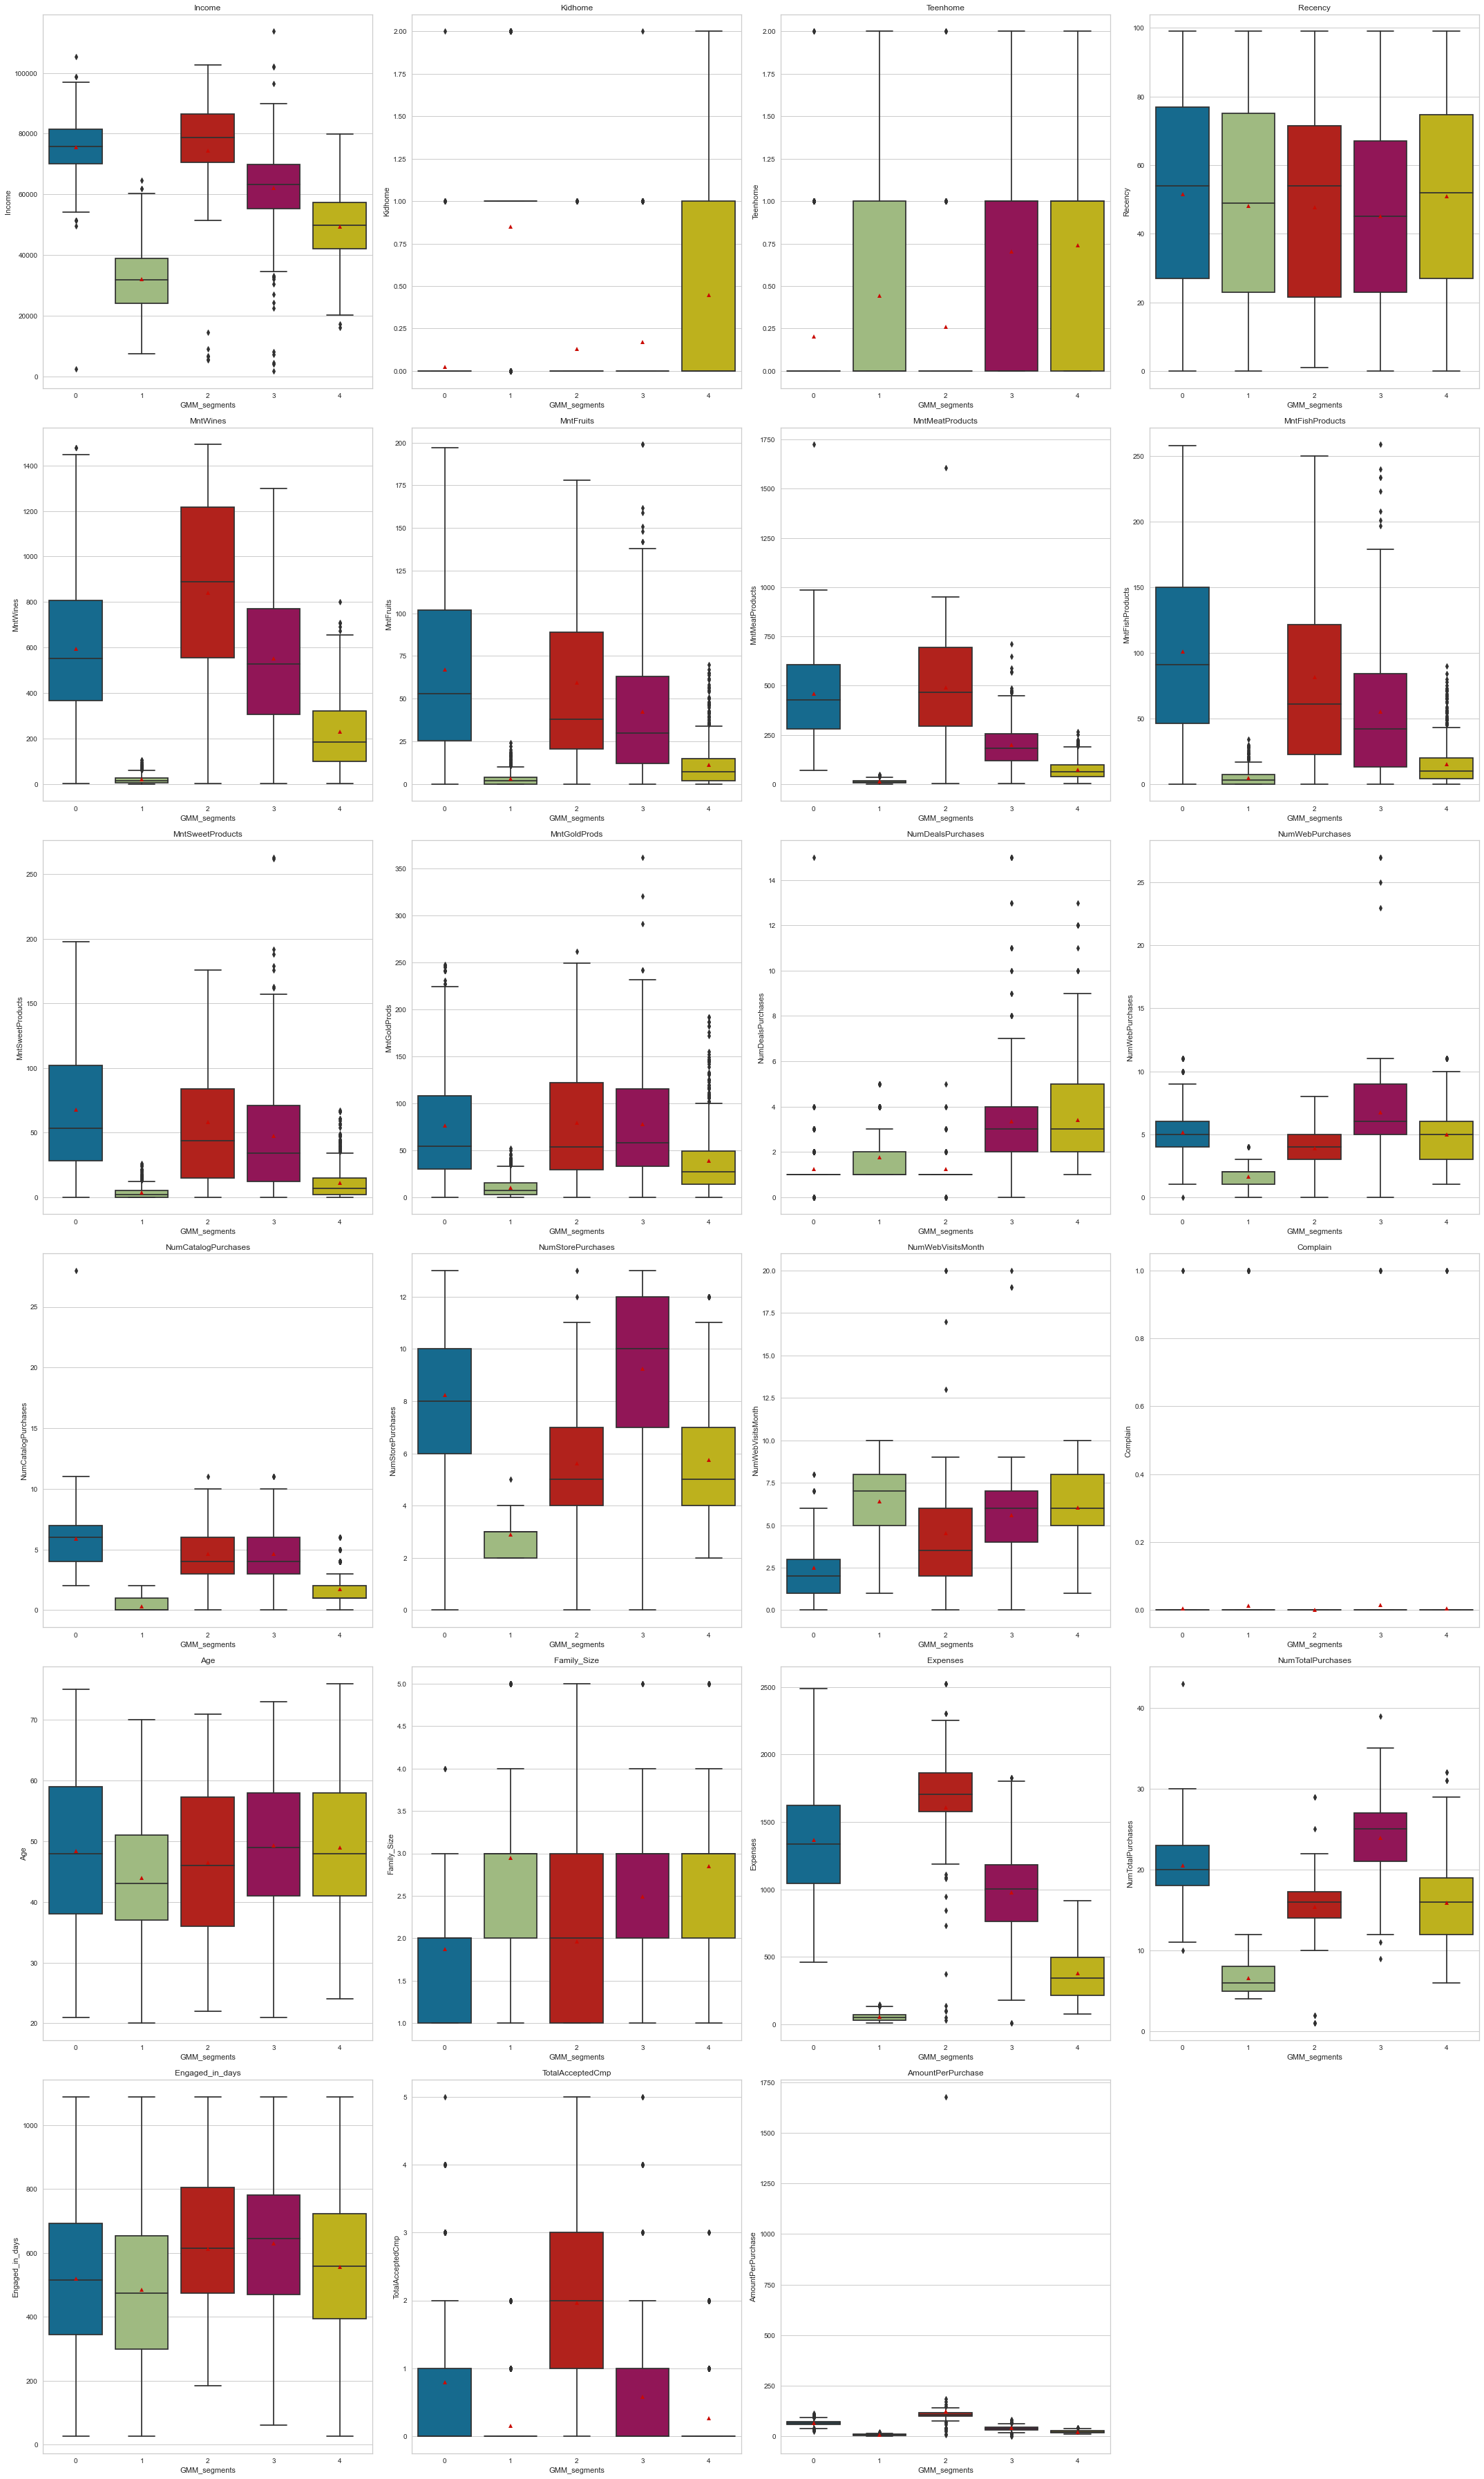

In [67]:
# Create boxplot for each of the variables
col_for_box = ['Income','Kidhome','Teenhome','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Complain','Age','Family_Size','Expenses','NumTotalPurchases','Engaged_in_days','TotalAcceptedCmp','AmountPerPurchase']

all_col = col_for_box

plt.figure(figsize = (30, 50))

for i, variable in enumerate(all_col):
    plt.subplot(6, 4, i + 1)
    
    sns.boxplot(y=data[variable], x=data['GMM_segments'],showmeans=True)
    
    plt.tight_layout()
    
    plt.title(variable)

plt.show()

## **Conclusion and Recommendations**

- **Refined Insights:** What are the most meaningful insights from the data relevant to the problem?

- **Comparison of various techniques and their relative performance:** How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

- **Proposal for the final solution design:** What model do you propose to be adopted? Why is this the best solution to adopt?